In [1]:
%load_ext autoreload
%autoreload 2


In [41]:
import os
from os.path import join
import pickle as pkl
import torch
import torch as th
from tqdm import tqdm
import pandas as pd
import numpy as np
import seaborn as sns
import einops
import matplotlib.pyplot as plt
from easydict import EasyDict as edict
import matplotlib.pyplot as plt 
from tqdm.auto import tqdm
from collections import defaultdict
%matplotlib inline
plt.rcParams['figure.dpi'] = 72
plt.rcParams['figure.figsize'] = [6.0, 4.0]
plt.rcParams['figure.edgecolor'] = (1, 1, 1, 0)
plt.rcParams['figure.facecolor'] = (1, 1, 1, 0)
# vector graphics type
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

In [27]:
import sys
sys.path.append("/n/home12/binxuwang/Github/mini_edm")
sys.path.append("/n/home12/binxuwang/Github/DiffusionReasoning")
sys.path.append("/n/home12/binxuwang/Github/DiT")
from train_edm import create_model, edm_sampler, EDM
from edm_utils import edm_sampler_inpaint, create_edm, get_default_config, create_edm_new
# from rule_utils import get_rule_img, get_obj_list, get_rule_list
# from rule_utils import check_consistent
from dataset_utils import train_data2attr_tsr,load_raw_data,load_PGM_abstract
from rule_new_utils import check_r3_r2_batch, infer_rule_from_sample_batch, compute_rule_statistics

In [5]:
import circuit_toolkit
print(circuit_toolkit.__file__)
from circuit_toolkit.plot_utils import saveallforms
from circuit_toolkit.layer_hook_utils import print_specific_layer, get_module_name_shapes, featureFetcher_module

/n/home12/binxuwang/Github/circuit_toolkit/circuit_toolkit/__init__.py


In [6]:
!cd $STORE_DIR/DL_Projects/mini_edm/exps;pwd

/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/mini_edm/exps


In [9]:
tabdir = "/n/home12/binxuwang/Github/DiffusionReasoning/Tables"
exproot = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/mini_edm/exps"

In [13]:
syndf_EDM = pd.read_csv(join(tabdir, "EDM_raven_tensorboard_data_last10.csv"), index_col=0)
tb_data_col_EDM = pkl.load(open(join(tabdir, "EDM_raven_tensorboard_raw_data.pkl"), "rb"))

In [16]:
from posthoc_analysis_utils import sweep_collect_eval_data, extract_rule_list_from_eval_col_Diffusion, format_rule_list_to_mat, visualize_indiv_rule_dynam, extract_and_convert, visualize_train_heldout_rule


In [17]:
syndf_EDM["heldout"] = syndf_EDM.index.map(lambda x: "_heldout0" in x)
syndf_EDM["scale"] = syndf_EDM.index.map(lambda x: "EDMx3" if "BigBlnrX3" in x else "EDMx2" if "WideBlnrX3" in x else "EDMx1" if "BaseBlnrX3" in x else None)
syndf_EDM["dataset_size"] = syndf_EDM.index.map(extract_and_convert)
syndf_EDM["Rules/c23"] = syndf_EDM["Rules/c2"] + syndf_EDM["Rules/c3"]
syndf_EDM["Rules/c23_cnt"] = syndf_EDM["Rules/c2_cnt"] + syndf_EDM["Rules/c3_cnt"]

In [24]:
syndf_EDM.query("heldout==True and dataset_size == 0.16").loc["WideBlnrX3_new_stream0_16M_heldout0"].full_name

'WideBlnrX3_new_stream0_16M_heldout0_RAVEN10_abstract_20240708-2054/tensorboard_logs'

In [61]:
!ls {ckptdir}

ema_100000.pth	ema_220000.pth	ema_360000.pth	ema_480000.pth	ema_60000.pth
ema_120000.pth	ema_240000.pth	ema_380000.pth	ema_500000.pth	ema_620000.pth
ema_140000.pth	ema_260000.pth	ema_400000.pth	ema_520000.pth	ema_640000.pth
ema_160000.pth	ema_280000.pth	ema_40000.pth	ema_540000.pth	ema_660000.pth
ema_180000.pth	ema_300000.pth	ema_420000.pth	ema_560000.pth	ema_680000.pth
ema_200000.pth	ema_320000.pth	ema_440000.pth	ema_580000.pth	ema_700000.pth
ema_20000.pth	ema_340000.pth	ema_460000.pth	ema_600000.pth	ema_80000.pth


In [10]:
DATASET="RAVEN10_abstract"
# --layers_per_block 2 --model_channels 128 --channel_mult 1 2 4 --attn_resolutions 9 3 --train_batch_size 256 --spatial_matching bilinear
config_ft = get_default_config(DATASET, layers_per_block=2, 
                               model_channels=128, 
                               channel_mult=[1, 2, 4], 
                               attn_resolutions=[9, 3], 
                               spatial_matching="bilinear")
device = "cuda"

In [29]:
# Xmean = torch.tensor([1.5, 2.5, 2.5]).view(1, 3, 1, 1).to(device)
# Xstd = torch.tensor([2.5, 3.5, 3.5]).view(1, 3, 1, 1).to(device)
dataset_Xmean = th.tensor([1.5, 2.5, 2.5]).view(1, 3, 1, 1).to(device)
dataset_Xstd = th.tensor([2.5, 3.5, 3.5]).view(1, 3, 1, 1).to(device)

In [26]:
epoch = 999999
expname = "WideBlnrX3_new_stream0_16M_heldout0_RAVEN10_abstract_20240708-2054"
expdir = join(exproot, expname)
ckptdir = join(expdir, "checkpoints")
repr_expdir = join(expdir, "repr_classifier")
os.makedirs(repr_expdir, exist_ok=True)
edm, model_EDM = create_edm_new(ckptdir + f"/ema_{epoch}.pth", config_ft, device) 

In [124]:
!ls {ckptdir}

ema_100000.pth	ema_280000.pth	ema_460000.pth	ema_640000.pth	ema_820000.pth
ema_120000.pth	ema_300000.pth	ema_480000.pth	ema_660000.pth	ema_840000.pth
ema_140000.pth	ema_320000.pth	ema_500000.pth	ema_680000.pth	ema_860000.pth
ema_160000.pth	ema_340000.pth	ema_520000.pth	ema_700000.pth	ema_880000.pth
ema_180000.pth	ema_360000.pth	ema_540000.pth	ema_720000.pth	ema_900000.pth
ema_200000.pth	ema_380000.pth	ema_560000.pth	ema_740000.pth	ema_920000.pth
ema_20000.pth	ema_400000.pth	ema_580000.pth	ema_760000.pth	ema_940000.pth
ema_220000.pth	ema_40000.pth	ema_600000.pth	ema_780000.pth	ema_960000.pth
ema_240000.pth	ema_420000.pth	ema_60000.pth	ema_800000.pth	ema_980000.pth
ema_260000.pth	ema_440000.pth	ema_620000.pth	ema_80000.pth	ema_999999.pth


### Test sampling and accuracy

In [30]:
latents = torch.randn(1024, 3, 9, 9).to(device)
samples = edm_sampler(edm, latents, num_steps=100)
samples = samples * dataset_Xstd + dataset_Xmean
r3_list, r2_list, rule_col = infer_rule_from_sample_batch(samples.cpu())
C3_count, C2_count, anyvalid_count, total = compute_rule_statistics(r3_list, r2_list, rule_col, verbose=True)

C3: 504/1024 (0.49), C3 + C2: 697/1024 (0.68), AnyValid: 2231/3072 (0.73)


### Training data

In [31]:
train_attrs = np.load("/n/home12/binxuwang/Github/DiffusionReasoning/attr_all.npy")
train_attrs = th.from_numpy(train_attrs).to(int)
train_row_img = einops.rearrange(train_attrs, 'c s pnl (H W) att -> c s att H (pnl W)', H=3, W=3, att=3, pnl=3)
train_sample_img = einops.rearrange(train_row_img, 'c (S R) att H W -> c S att (R H) W', R=3,att=3, H=3, W=9)
labels_tsr = torch.arange(len(train_sample_img)).to(int).view(-1,1).repeat(1, train_sample_img.shape[1])

In [32]:
from torch.utils.data import Dataset, DataLoader, TensorDataset
X_train = train_sample_img[:, :3000]
y_train = labels_tsr[:, :3000]
X_test = train_sample_img[:, 3000:]
y_test = labels_tsr[:, 3000:]
X_train = X_train.reshape(-1, 3, 9, 9)
y_train = y_train.reshape(-1)
X_test = X_test.reshape(-1, 3, 9, 9)
y_test = y_test.reshape(-1)
print(X_train.shape, y_train.shape)
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

torch.Size([120000, 3, 9, 9]) torch.Size([120000])


### Hook model and retrieve feature

In [36]:
from repr_probe_lib import extract_features_DiT, train_pca_sgd_classifiers 

In [35]:
get_module_name_shapes(model_EDM, inputs_list=[th.randn(2, 3, 9, 9).to(device), th.rand(2, ).to(device), None], deepest=3);

------------------------------------------------------------------------------------------------------------------------------------------------------
      Layer Id                                           inshape                    outshape                            Type   Module Path                      
        0                                             (2, 3, 9, 9)                (2, 3, 9, 9)                         [Input]   Image                            
        1                                                   [(2,)]                    (2, 128)           [PositionalEmbedding]   .map_noise                       
        2                                               [(2, 128)]                    (2, 512)                        [Linear]   .map_layer0                      
        3                                               [(2, 512)]                    (2, 512)                        [Linear]   .map_layer1                      
        4                           

In [52]:
list(model_EDM.dec)

['1x1_in0',
 '1x1_in1',
 '1x1_block0',
 '1x1_block1',
 '1x1_block2',
 '3x3_up',
 '3x3_block0',
 '3x3_block1',
 '3x3_block2',
 '9x9_up',
 '9x9_block0',
 '9x9_block1',
 '9x9_block2',
 '9x9_aux_norm',
 '9x9_aux_conv']

In [69]:
def extract_features_EDM(model_EDM, fetcher, data_loader, 
                         dataset_Xmean, dataset_Xstd, t_scalar,
                         device='cuda', progress_bar=True):
    feature_col = defaultdict(list)
    loader = tqdm(data_loader) if progress_bar else data_loader
    for X_batch, y_batch in loader:
        t_vec = th.ones(X_batch.shape[0], dtype=torch.float, device=device) * t_scalar
        X_batch_norm = (X_batch.cuda().float() - dataset_Xmean) / dataset_Xstd
        with th.no_grad():
            model_EDM.model_forward_wrapper(X_batch_norm, t_vec, use_ema=True, labels=None)
        feature_col["input"].append(X_batch.float())
        for key, activations in fetcher.activations.items():
            feature_col[key].append(activations)
    for key in feature_col.keys():
        feature_col[key] = th.cat(feature_col[key], dim=0)
        print(key, feature_col[key].shape)
    return feature_col


In [37]:
fetcher = featureFetcher_module()
for blockname in list(model_EDM.enc):
    fetcher.record_module(model_EDM.enc[blockname], target_name=f"enc.{blockname}")
for blockname in list(model_EDM.dec):
    fetcher.record_module(model_EDM.dec[blockname], target_name=f"dec.{blockname}")
# fetcher.record_module(model.blocks[11], target_name="blocks.11")
# for i in range(12):
#     fetcher.record_module(model.blocks[i], target_name=f"blocks.{i}")
# fetcher.record_module(model.enc["9x9_conv"], target_name="enc.9x9_conv",)
# fetcher.record_module(model.enc["9x9_block0"], target_name="enc.9x9_block0",)
# fetcher.record_module(model.enc["9x9_block1"], target_name="enc.9x9_block1",)
# fetcher.record_module(model.enc["3x3_down"], target_name="enc.3x3_down",)
# fetcher.record_module(model.enc["3x3_block0"], target_name="enc.3x3_block0",)
# fetcher.record_module(model.enc["3x3_block1"], target_name="enc.3x3_block1",)
# fetcher.record_module(model.enc["1x1_down"], target_name="enc.1x1_down",)
# fetcher.record_module(model.enc["1x1_block0"], target_name="enc.1x1_block0",)
# fetcher.record_module(model.enc["1x1_block1"], target_name="enc.1x1_block1",)
# fetcher.record_module(model.dec["1x1_in0"], target_name="dec.1x1_in0",)
# fetcher.record_module(model.dec["1x1_in1"], target_name="dec.1x1_in1",)
# fetcher.record_module(model.dec["1x1_block0"], target_name="dec.1x1_block0",)
# fetcher.record_module(model.dec["1x1_block1"], target_name="dec.1x1_block1",)
# fetcher.record_module(model.dec["1x1_block2"], target_name="dec.1x1_block2",)
# fetcher.record_module(model.dec["3x3_up"], target_name="dec.3x3_up",)
# fetcher.record_module(model.dec["3x3_block0"], target_name="dec.3x3_block0",)
# fetcher.record_module(model.dec["3x3_block1"], target_name="dec.3x3_block1",)
# fetcher.record_module(model.dec["3x3_block2"], target_name="dec.3x3_block2",)
# fetcher.record_module(model.dec["9x9_up"], target_name="dec.9x9_up",)
# fetcher.record_module(model.dec["9x9_block0"], target_name="dec.9x9_block0",)
# fetcher.record_module(model.dec["9x9_block1"], target_name="dec.9x9_block1",)
# fetcher.record_module(model.dec["9x9_block2"], target_name="dec.9x9_block2",)

In [ ]:
# input torch.Size([40000, 3, 9, 9])
# enc.9x9_conv torch.Size([40000, 128, 9, 9])
# enc.9x9_block0 torch.Size([40000, 128, 9, 9])
# enc.9x9_block1 torch.Size([40000, 128, 9, 9])
# enc.3x3_down torch.Size([40000, 128, 3, 3])
# enc.3x3_block0 torch.Size([40000, 256, 3, 3])
# enc.3x3_block1 torch.Size([40000, 256, 3, 3])
# enc.1x1_down torch.Size([40000, 256, 1, 1])
# enc.1x1_block0 torch.Size([40000, 512, 1, 1])
# enc.1x1_block1 torch.Size([40000, 512, 1, 1])
# dec.1x1_in0 torch.Size([40000, 512, 1, 1])
# dec.1x1_in1 torch.Size([40000, 512, 1, 1])
# dec.1x1_block0 torch.Size([40000, 512, 1, 1])
# dec.1x1_block1 torch.Size([40000, 512, 1, 1])
# dec.1x1_block2 torch.Size([40000, 512, 1, 1])
# dec.3x3_up torch.Size([40000, 512, 1, 1])
# dec.3x3_block0 torch.Size([40000, 256, 3, 3])
# dec.3x3_block1 torch.Size([40000, 256, 3, 3])
# dec.3x3_block2 torch.Size([40000, 256, 3, 3])
# dec.9x9_up torch.Size([40000, 256, 7, 7])
# dec.9x9_block0 torch.Size([40000, 128, 9, 9])
# dec.9x9_block1 torch.Size([40000, 128, 9, 9])
# dec.9x9_block2 torch.Size([40000, 128, 9, 9])
# dec.9x9_aux_norm torch.Size([40000, 128, 9, 9])
# dec.9x9_aux_conv torch.Size([40000, 3, 9, 9])

In [ ]:
# enc.1x1_block0 torch.Size([120000, 512, 1, 1])
# enc.1x1_block1 torch.Size([120000, 512, 1, 1])
# dec.1x1_in0 torch.Size([120000, 512, 1, 1])
# dec.1x1_in1 torch.Size([120000, 512, 1, 1])
# dec.1x1_block0 torch.Size([120000, 512, 1, 1])
# dec.1x1_block1 torch.Size([120000, 512, 1, 1])
# dec.1x1_block2 torch.Size([120000, 512, 1, 1])
# dec.3x3_up torch.Size([120000, 512, 1, 1])

In [53]:
fetcher = featureFetcher_module()
record_module_list = ["input",
               'enc.9x9_conv',
                'enc.3x3_down',
                'enc.1x1_down',
                'dec.1x1_in0',
                'dec.1x1_in1',
                'dec.3x3_up',
                'dec.9x9_up',
                # 'dec.9x9_block2',
                "dec.9x9_aux_norm",
                "dec.9x9_aux_conv", ]
for blockname in list(model_EDM.enc):
    if f"enc.{blockname}" in record_module_list:
        fetcher.record_module(model_EDM.enc[blockname], target_name=f"enc.{blockname}")
for blockname in list(model_EDM.dec):
    if f"dec.{blockname}" in record_module_list:
        fetcher.record_module(model_EDM.dec[blockname], target_name=f"dec.{blockname}")

### Less preconditioning

In [54]:
# Now use the function for both training and testing data
train_loader = DataLoader(train_dataset, batch_size=2048, shuffle=False, drop_last=False)
test_loader = DataLoader(test_dataset, batch_size=2048, shuffle=False, drop_last=False)
t_scalar = -2.0
feature_col = extract_features_EDM(model_EDM, fetcher, train_loader, dataset_Xmean, dataset_Xstd, t_scalar)
feature_col_test = extract_features_EDM(model_EDM, fetcher, test_loader, dataset_Xmean, dataset_Xstd, t_scalar)

  0%|          | 0/59 [00:00<?, ?it/s]

input torch.Size([120000, 3, 9, 9])
enc.9x9_conv torch.Size([120000, 128, 9, 9])
enc.3x3_down torch.Size([120000, 128, 3, 3])
enc.1x1_down torch.Size([120000, 256, 1, 1])
dec.1x1_in0 torch.Size([120000, 512, 1, 1])
dec.1x1_in1 torch.Size([120000, 512, 1, 1])
dec.3x3_up torch.Size([120000, 512, 1, 1])
dec.9x9_up torch.Size([120000, 256, 7, 7])
dec.9x9_aux_norm torch.Size([120000, 128, 9, 9])
dec.9x9_aux_conv torch.Size([120000, 3, 9, 9])


  0%|          | 0/20 [00:00<?, ?it/s]

input torch.Size([40000, 3, 9, 9])
enc.9x9_conv torch.Size([40000, 128, 9, 9])
enc.3x3_down torch.Size([40000, 128, 3, 3])
enc.1x1_down torch.Size([40000, 256, 1, 1])
dec.1x1_in0 torch.Size([40000, 512, 1, 1])
dec.1x1_in1 torch.Size([40000, 512, 1, 1])
dec.3x3_up torch.Size([40000, 512, 1, 1])
dec.9x9_up torch.Size([40000, 256, 7, 7])
dec.9x9_aux_norm torch.Size([40000, 128, 9, 9])
dec.9x9_aux_conv torch.Size([40000, 3, 9, 9])


In [56]:
feature_avg_col = {k: v.mean(dim=(2,3)) for k, v in feature_col.items()}
feature_avg_col_test = {k: v.mean(dim=(2,3)) for k, v in feature_col_test.items()}
feature_sel_col = {k: v for k, v in feature_col.items() if "1x1" in k}
feature_sel_col_test = {k: v for k, v in feature_col_test.items() if "1x1" in k}

In [57]:
model_PCA_col, PC_proj_col, results_col = train_pca_sgd_classifiers(
    feature_sel_col, feature_sel_col_test, y_train, y_test,
    PC_dim=1024, noPCA=True, num_classes=40, batch_size=None,
    num_epochs=5000, print_every=250, eval_every=1000, learning_rate=0.005,
    device='cuda'
)

Processing layer: enc.1x1_down
Epoch [1/5000], Loss: 3.8196, Accuracy: 0.0260
Epoch [250/5000], Loss: 1.3119, Accuracy: 0.5873
Epoch [500/5000], Loss: 1.2088, Accuracy: 0.6154
Epoch [750/5000], Loss: 1.1605, Accuracy: 0.6279
Epoch [1000/5000], Loss: 1.1312, Accuracy: 0.6362
Test Accuracy: 0.6131
Epoch [1250/5000], Loss: 1.1111, Accuracy: 0.6423
Epoch [1500/5000], Loss: 1.0963, Accuracy: 0.6467
Epoch [1750/5000], Loss: 1.0850, Accuracy: 0.6502
Epoch [2000/5000], Loss: 1.0760, Accuracy: 0.6535
Test Accuracy: 0.6246
Epoch [2250/5000], Loss: 1.0686, Accuracy: 0.6554
Epoch [2500/5000], Loss: 1.0626, Accuracy: 0.6571
Epoch [2750/5000], Loss: 1.0575, Accuracy: 0.6584
Epoch [3000/5000], Loss: 1.0532, Accuracy: 0.6594
Test Accuracy: 0.6287
Epoch [3250/5000], Loss: 1.0496, Accuracy: 0.6605
Epoch [3500/5000], Loss: 1.0464, Accuracy: 0.6614
Epoch [3750/5000], Loss: 1.0437, Accuracy: 0.6625
Epoch [4000/5000], Loss: 1.0414, Accuracy: 0.6629
Test Accuracy: 0.6316
Epoch [4250/5000], Loss: 1.0395, Accu

### With preconditioning

Try to fetch from edm model, preconditioning? 

In [76]:
edm(torch.randn(12, 3, 9, 9).to(device), torch.rand(12, ).to(device), use_ema=False, labels=None).shape
# for key in feature_col:
#     feature_col[key] = th.cat(feature_col[key], dim=0)
#     print(f"{key}: {feature_col[key].shape}")

torch.Size([12, 3, 9, 9])

In [77]:
for key, activations in fetcher.activations.items():
    print(key, activations.shape)   

enc.9x9_conv torch.Size([12, 128, 9, 9])
enc.3x3_down torch.Size([12, 128, 3, 3])
enc.1x1_down torch.Size([12, 256, 1, 1])
dec.1x1_in0 torch.Size([12, 512, 1, 1])
dec.1x1_in1 torch.Size([12, 512, 1, 1])
dec.3x3_up torch.Size([12, 512, 1, 1])
dec.9x9_up torch.Size([12, 256, 7, 7])
dec.9x9_aux_norm torch.Size([12, 128, 9, 9])
dec.9x9_aux_conv torch.Size([12, 3, 9, 9])


In [79]:
fetcher = featureFetcher_module()
record_module_list = ["input",
               'enc.9x9_conv',
                'enc.3x3_down',
                'enc.1x1_down',
                'dec.1x1_in0',
                'dec.1x1_in1',
                'dec.3x3_up',
                'dec.9x9_up',
                # 'dec.9x9_block2',
                "dec.9x9_aux_norm",
                "dec.9x9_aux_conv", ]
for blockname in list(edm.ema.enc):
    if f"enc.{blockname}" in record_module_list:
        fetcher.record_module(edm.ema.enc[blockname], target_name=f"enc.{blockname}")
for blockname in list(edm.ema.dec):
    if f"dec.{blockname}" in record_module_list:
        fetcher.record_module(edm.ema.dec[blockname], target_name=f"dec.{blockname}")

In [80]:
# Now use the function for both training and testing data
train_loader = DataLoader(train_dataset, batch_size=2048, shuffle=False, drop_last=False)
test_loader = DataLoader(test_dataset, batch_size=2048, shuffle=False, drop_last=False)
t_scalar = 0.1
feature_col = extract_features_EDM(edm, fetcher, train_loader, dataset_Xmean, dataset_Xstd, t_scalar)
feature_col_test = extract_features_EDM(edm, fetcher, test_loader, dataset_Xmean, dataset_Xstd, t_scalar)

  0%|          | 0/59 [00:00<?, ?it/s]

input torch.Size([120000, 3, 9, 9])
enc.9x9_conv torch.Size([120000, 128, 9, 9])
enc.3x3_down torch.Size([120000, 128, 3, 3])
enc.1x1_down torch.Size([120000, 256, 1, 1])
dec.1x1_in0 torch.Size([120000, 512, 1, 1])
dec.1x1_in1 torch.Size([120000, 512, 1, 1])
dec.3x3_up torch.Size([120000, 512, 1, 1])
dec.9x9_up torch.Size([120000, 256, 7, 7])
dec.9x9_aux_norm torch.Size([120000, 128, 9, 9])
dec.9x9_aux_conv torch.Size([120000, 3, 9, 9])


  0%|          | 0/20 [00:00<?, ?it/s]

input torch.Size([40000, 3, 9, 9])
enc.9x9_conv torch.Size([40000, 128, 9, 9])
enc.3x3_down torch.Size([40000, 128, 3, 3])
enc.1x1_down torch.Size([40000, 256, 1, 1])
dec.1x1_in0 torch.Size([40000, 512, 1, 1])
dec.1x1_in1 torch.Size([40000, 512, 1, 1])
dec.3x3_up torch.Size([40000, 512, 1, 1])
dec.9x9_up torch.Size([40000, 256, 7, 7])
dec.9x9_aux_norm torch.Size([40000, 128, 9, 9])
dec.9x9_aux_conv torch.Size([40000, 3, 9, 9])


In [81]:
feature_avg_col = {k: v.mean(dim=(2,3)) for k, v in feature_col.items()}
feature_avg_col_test = {k: v.mean(dim=(2,3)) for k, v in feature_col_test.items()}
feature_sel_col = {k: v for k, v in feature_col.items() if "1x1" in k}
feature_sel_col_test = {k: v for k, v in feature_col_test.items() if "1x1" in k}

In [82]:
model_PCA_col, PC_proj_col, results_col = train_pca_sgd_classifiers(
    feature_sel_col, feature_sel_col_test, y_train, y_test,
    PC_dim=1024, noPCA=True, num_classes=40, batch_size=None,
    num_epochs=5000, print_every=250, eval_every=1000, learning_rate=0.005,
    device='cuda'
)

Processing layer: enc.1x1_down
Epoch [1/5000], Loss: 3.7498, Accuracy: 0.0355
Epoch [250/5000], Loss: 0.1977, Accuracy: 0.9297
Epoch [500/5000], Loss: 0.1715, Accuracy: 0.9375
Epoch [750/5000], Loss: 0.1593, Accuracy: 0.9410
Epoch [1000/5000], Loss: 0.1519, Accuracy: 0.9431
Test Accuracy: 0.9291
Epoch [1250/5000], Loss: 0.1467, Accuracy: 0.9446
Epoch [1500/5000], Loss: 0.1427, Accuracy: 0.9457
Epoch [1750/5000], Loss: 0.1396, Accuracy: 0.9465
Epoch [2000/5000], Loss: 0.1370, Accuracy: 0.9475
Test Accuracy: 0.9304
Epoch [2250/5000], Loss: 0.1348, Accuracy: 0.9479
Epoch [2500/5000], Loss: 0.1329, Accuracy: 0.9486
Epoch [2750/5000], Loss: 0.1312, Accuracy: 0.9492
Epoch [3000/5000], Loss: 0.1297, Accuracy: 0.9497
Test Accuracy: 0.9316
Epoch [3250/5000], Loss: 0.1283, Accuracy: 0.9502
Epoch [3500/5000], Loss: 0.1271, Accuracy: 0.9505
Epoch [3750/5000], Loss: 0.1260, Accuracy: 0.9509
Epoch [4000/5000], Loss: 0.1249, Accuracy: 0.9513
Test Accuracy: 0.9315
Epoch [4250/5000], Loss: 0.1240, Accu

### Earlier time points 0.02?

In [83]:
fetcher = featureFetcher_module()
record_module_list = ["input",
               'enc.9x9_conv',
                'enc.3x3_down',
                'enc.1x1_down',
                'dec.1x1_in0',
                'dec.1x1_in1',
                'dec.3x3_up',
                'dec.9x9_up',
                # 'dec.9x9_block2',
                "dec.9x9_aux_norm",
                "dec.9x9_aux_conv", ]
for blockname in list(edm.ema.enc):
    if f"enc.{blockname}" in record_module_list:
        fetcher.record_module(edm.ema.enc[blockname], target_name=f"enc.{blockname}")
for blockname in list(edm.ema.dec):
    if f"dec.{blockname}" in record_module_list:
        fetcher.record_module(edm.ema.dec[blockname], target_name=f"dec.{blockname}")

In [84]:
# Now use the function for both training and testing data
train_loader = DataLoader(train_dataset, batch_size=2048, shuffle=False, drop_last=False)
test_loader = DataLoader(test_dataset, batch_size=2048, shuffle=False, drop_last=False)
t_scalar = 0.02
feature_col = extract_features_EDM(edm, fetcher, train_loader, dataset_Xmean, dataset_Xstd, t_scalar)
feature_col_test = extract_features_EDM(edm, fetcher, test_loader, dataset_Xmean, dataset_Xstd, t_scalar)

  0%|          | 0/59 [00:00<?, ?it/s]

input torch.Size([120000, 3, 9, 9])
enc.9x9_conv torch.Size([120000, 128, 9, 9])
enc.3x3_down torch.Size([120000, 128, 3, 3])
enc.1x1_down torch.Size([120000, 256, 1, 1])
dec.1x1_in0 torch.Size([120000, 512, 1, 1])
dec.1x1_in1 torch.Size([120000, 512, 1, 1])
dec.3x3_up torch.Size([120000, 512, 1, 1])
dec.9x9_up torch.Size([120000, 256, 7, 7])
dec.9x9_aux_norm torch.Size([120000, 128, 9, 9])
dec.9x9_aux_conv torch.Size([120000, 3, 9, 9])


  0%|          | 0/20 [00:00<?, ?it/s]

input torch.Size([40000, 3, 9, 9])
enc.9x9_conv torch.Size([40000, 128, 9, 9])
enc.3x3_down torch.Size([40000, 128, 3, 3])
enc.1x1_down torch.Size([40000, 256, 1, 1])
dec.1x1_in0 torch.Size([40000, 512, 1, 1])
dec.1x1_in1 torch.Size([40000, 512, 1, 1])
dec.3x3_up torch.Size([40000, 512, 1, 1])
dec.9x9_up torch.Size([40000, 256, 7, 7])
dec.9x9_aux_norm torch.Size([40000, 128, 9, 9])
dec.9x9_aux_conv torch.Size([40000, 3, 9, 9])


In [85]:
feature_avg_col = {k: v.mean(dim=(2,3)) for k, v in feature_col.items()}
feature_avg_col_test = {k: v.mean(dim=(2,3)) for k, v in feature_col_test.items()}
feature_sel_col = {k: v for k, v in feature_col.items() if "1x1" in k}
feature_sel_col_test = {k: v for k, v in feature_col_test.items() if "1x1" in k}

In [86]:
model_PCA_col, PC_proj_col, results_col = train_pca_sgd_classifiers(
    feature_sel_col, feature_sel_col_test, y_train, y_test,
    PC_dim=1024, noPCA=True, num_classes=40, batch_size=None,
    num_epochs=5000, print_every=250, eval_every=1000, learning_rate=0.005,
    device='cuda'
)

Processing layer: enc.1x1_down
Epoch [1/5000], Loss: 3.8480, Accuracy: 0.0254
Epoch [250/5000], Loss: 0.2827, Accuracy: 0.9009
Epoch [500/5000], Loss: 0.2445, Accuracy: 0.9123
Epoch [750/5000], Loss: 0.2267, Accuracy: 0.9176
Epoch [1000/5000], Loss: 0.2157, Accuracy: 0.9210
Test Accuracy: 0.9041
Epoch [1250/5000], Loss: 0.2079, Accuracy: 0.9236
Epoch [1500/5000], Loss: 0.2020, Accuracy: 0.9255
Epoch [1750/5000], Loss: 0.1972, Accuracy: 0.9270
Epoch [2000/5000], Loss: 0.1932, Accuracy: 0.9284
Test Accuracy: 0.9082
Epoch [2250/5000], Loss: 0.1898, Accuracy: 0.9294
Epoch [2500/5000], Loss: 0.1869, Accuracy: 0.9302
Epoch [2750/5000], Loss: 0.1844, Accuracy: 0.9311
Epoch [3000/5000], Loss: 0.1821, Accuracy: 0.9319
Test Accuracy: 0.9088
Epoch [3250/5000], Loss: 0.1800, Accuracy: 0.9325
Epoch [3500/5000], Loss: 0.1782, Accuracy: 0.9332
Epoch [3750/5000], Loss: 0.1765, Accuracy: 0.9337
Epoch [4000/5000], Loss: 0.1750, Accuracy: 0.9342
Test Accuracy: 0.9084
Epoch [4250/5000], Loss: 0.1736, Accu

### Earlier time points 0.002?

In [87]:
fetcher = featureFetcher_module()
record_module_list = ["input",
               'enc.9x9_conv',
                'enc.3x3_down',
                'enc.1x1_down',
                'dec.1x1_in0',
                'dec.1x1_in1',
                'dec.3x3_up',
                'dec.9x9_up',
                # 'dec.9x9_block2',
                "dec.9x9_aux_norm",
                "dec.9x9_aux_conv", ]
for blockname in list(edm.ema.enc):
    if f"enc.{blockname}" in record_module_list:
        fetcher.record_module(edm.ema.enc[blockname], target_name=f"enc.{blockname}")
for blockname in list(edm.ema.dec):
    if f"dec.{blockname}" in record_module_list:
        fetcher.record_module(edm.ema.dec[blockname], target_name=f"dec.{blockname}")

In [88]:
# Now use the function for both training and testing data
train_loader = DataLoader(train_dataset, batch_size=2048, shuffle=False, drop_last=False)
test_loader = DataLoader(test_dataset, batch_size=2048, shuffle=False, drop_last=False)
t_scalar = 0.002
feature_col = extract_features_EDM(edm, fetcher, train_loader, dataset_Xmean, dataset_Xstd, t_scalar)
feature_col_test = extract_features_EDM(edm, fetcher, test_loader, dataset_Xmean, dataset_Xstd, t_scalar)

  0%|          | 0/59 [00:00<?, ?it/s]

input torch.Size([120000, 3, 9, 9])
enc.9x9_conv torch.Size([120000, 128, 9, 9])
enc.3x3_down torch.Size([120000, 128, 3, 3])
enc.1x1_down torch.Size([120000, 256, 1, 1])
dec.1x1_in0 torch.Size([120000, 512, 1, 1])
dec.1x1_in1 torch.Size([120000, 512, 1, 1])
dec.3x3_up torch.Size([120000, 512, 1, 1])
dec.9x9_up torch.Size([120000, 256, 7, 7])
dec.9x9_aux_norm torch.Size([120000, 128, 9, 9])
dec.9x9_aux_conv torch.Size([120000, 3, 9, 9])


  0%|          | 0/20 [00:00<?, ?it/s]

input torch.Size([40000, 3, 9, 9])
enc.9x9_conv torch.Size([40000, 128, 9, 9])
enc.3x3_down torch.Size([40000, 128, 3, 3])
enc.1x1_down torch.Size([40000, 256, 1, 1])
dec.1x1_in0 torch.Size([40000, 512, 1, 1])
dec.1x1_in1 torch.Size([40000, 512, 1, 1])
dec.3x3_up torch.Size([40000, 512, 1, 1])
dec.9x9_up torch.Size([40000, 256, 7, 7])
dec.9x9_aux_norm torch.Size([40000, 128, 9, 9])
dec.9x9_aux_conv torch.Size([40000, 3, 9, 9])


In [89]:
feature_avg_col = {k: v.mean(dim=(2,3)) for k, v in feature_col.items()}
feature_avg_col_test = {k: v.mean(dim=(2,3)) for k, v in feature_col_test.items()}
feature_sel_col = {k: v for k, v in feature_col.items() if "1x1" in k}
feature_sel_col_test = {k: v for k, v in feature_col_test.items() if "1x1" in k}

In [90]:
model_PCA_col, PC_proj_col, results_col = train_pca_sgd_classifiers(
    feature_sel_col, feature_sel_col_test, y_train, y_test,
    PC_dim=1024, noPCA=True, num_classes=40, batch_size=None,
    num_epochs=5000, print_every=250, eval_every=1000, learning_rate=0.005,
    device='cuda'
)

Processing layer: enc.1x1_down
Epoch [1/5000], Loss: 3.8947, Accuracy: 0.0225
Epoch [250/5000], Loss: 0.3242, Accuracy: 0.8884
Epoch [500/5000], Loss: 0.2770, Accuracy: 0.9026
Epoch [750/5000], Loss: 0.2552, Accuracy: 0.9090
Epoch [1000/5000], Loss: 0.2418, Accuracy: 0.9128
Test Accuracy: 0.8963
Epoch [1250/5000], Loss: 0.2323, Accuracy: 0.9157
Epoch [1500/5000], Loss: 0.2252, Accuracy: 0.9181
Epoch [1750/5000], Loss: 0.2195, Accuracy: 0.9196
Epoch [2000/5000], Loss: 0.2148, Accuracy: 0.9211
Test Accuracy: 0.8998
Epoch [2250/5000], Loss: 0.2109, Accuracy: 0.9223
Epoch [2500/5000], Loss: 0.2074, Accuracy: 0.9230
Epoch [2750/5000], Loss: 0.2044, Accuracy: 0.9241
Epoch [3000/5000], Loss: 0.2017, Accuracy: 0.9250
Test Accuracy: 0.9005
Epoch [3250/5000], Loss: 0.1993, Accuracy: 0.9256
Epoch [3500/5000], Loss: 0.1971, Accuracy: 0.9264
Epoch [3750/5000], Loss: 0.1951, Accuracy: 0.9271
Epoch [4000/5000], Loss: 0.1933, Accuracy: 0.9276
Test Accuracy: 0.9012
Epoch [4250/5000], Loss: 0.1917, Accu

### Scaling of sigma

In [98]:
sigma_max = 80
sigma_min = 0.002
rho = 7
num_steps = 15
step_indices = np.arange(num_steps)
sigma_steps = (sigma_max ** (1 / rho) + step_indices / (num_steps - 1) * (sigma_min ** (1 / rho) - sigma_max ** (1 / rho))) ** rho
for sigma in sigma_steps:
    print(f"{sigma:.3f}")
sigma_steps


80.000
53.559
34.992
22.240
13.699
8.139
4.637
2.515
1.287
0.613
0.267
0.104
0.035
0.010
0.002


In [97]:
for sigma in np.logspace(np.log10(sigma_min), np.log10(sigma_max), num_steps):
    print(f"{sigma:.3f}")

0.002
0.004
0.009
0.019
0.041
0.088
0.188
0.400
0.853
1.818
3.875
8.259
17.606
37.529
80.000


### Dense sampling of time and sigma

  0%|          | 0/59 [00:00<?, ?it/s]

input torch.Size([120000, 3, 9, 9])
enc.9x9_conv torch.Size([120000, 128, 9, 9])
enc.3x3_down torch.Size([120000, 128, 3, 3])
enc.1x1_down torch.Size([120000, 256, 1, 1])
dec.1x1_in0 torch.Size([120000, 512, 1, 1])
dec.1x1_in1 torch.Size([120000, 512, 1, 1])
dec.3x3_up torch.Size([120000, 512, 1, 1])
dec.9x9_up torch.Size([120000, 256, 7, 7])
dec.9x9_aux_norm torch.Size([120000, 128, 9, 9])
dec.9x9_aux_conv torch.Size([120000, 3, 9, 9])


  0%|          | 0/20 [00:00<?, ?it/s]

input torch.Size([40000, 3, 9, 9])
enc.9x9_conv torch.Size([40000, 128, 9, 9])
enc.3x3_down torch.Size([40000, 128, 3, 3])
enc.1x1_down torch.Size([40000, 256, 1, 1])
dec.1x1_in0 torch.Size([40000, 512, 1, 1])
dec.1x1_in1 torch.Size([40000, 512, 1, 1])
dec.3x3_up torch.Size([40000, 512, 1, 1])
dec.9x9_up torch.Size([40000, 256, 7, 7])
dec.9x9_aux_norm torch.Size([40000, 128, 9, 9])
dec.9x9_aux_conv torch.Size([40000, 3, 9, 9])
Processing layer: enc.1x1_down
Epoch [1/5000], Loss: 3.8350, Accuracy: 0.0209
Epoch [500/5000], Loss: 2.4768, Accuracy: 0.2739
Epoch [1000/5000], Loss: 2.4026, Accuracy: 0.2884
Test Accuracy: 0.2786
Epoch [1500/5000], Loss: 2.3632, Accuracy: 0.2965
Epoch [2000/5000], Loss: 2.3380, Accuracy: 0.3025
Test Accuracy: 0.2905
Epoch [2500/5000], Loss: 2.3202, Accuracy: 0.3061
Epoch [3000/5000], Loss: 2.3069, Accuracy: 0.3097
Test Accuracy: 0.2991
Epoch [3500/5000], Loss: 2.2967, Accuracy: 0.3117
Epoch [4000/5000], Loss: 2.2887, Accuracy: 0.3140
Test Accuracy: 0.3016
Epoc

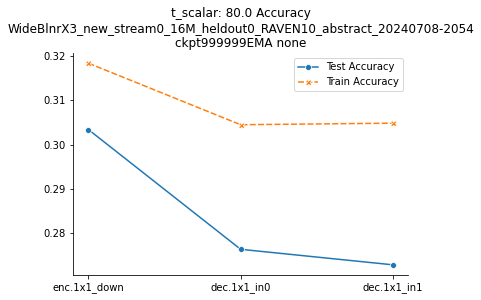

  0%|          | 0/59 [00:00<?, ?it/s]

input torch.Size([120000, 3, 9, 9])
enc.9x9_conv torch.Size([120000, 128, 9, 9])
enc.3x3_down torch.Size([120000, 128, 3, 3])
enc.1x1_down torch.Size([120000, 256, 1, 1])
dec.1x1_in0 torch.Size([120000, 512, 1, 1])
dec.1x1_in1 torch.Size([120000, 512, 1, 1])
dec.3x3_up torch.Size([120000, 512, 1, 1])
dec.9x9_up torch.Size([120000, 256, 7, 7])
dec.9x9_aux_norm torch.Size([120000, 128, 9, 9])
dec.9x9_aux_conv torch.Size([120000, 3, 9, 9])


  0%|          | 0/20 [00:00<?, ?it/s]

input torch.Size([40000, 3, 9, 9])
enc.9x9_conv torch.Size([40000, 128, 9, 9])
enc.3x3_down torch.Size([40000, 128, 3, 3])
enc.1x1_down torch.Size([40000, 256, 1, 1])
dec.1x1_in0 torch.Size([40000, 512, 1, 1])
dec.1x1_in1 torch.Size([40000, 512, 1, 1])
dec.3x3_up torch.Size([40000, 512, 1, 1])
dec.9x9_up torch.Size([40000, 256, 7, 7])
dec.9x9_aux_norm torch.Size([40000, 128, 9, 9])
dec.9x9_aux_conv torch.Size([40000, 3, 9, 9])
Processing layer: enc.1x1_down
Epoch [1/5000], Loss: 3.8296, Accuracy: 0.0258
Epoch [500/5000], Loss: 2.4187, Accuracy: 0.2867
Epoch [1000/5000], Loss: 2.3269, Accuracy: 0.3072
Test Accuracy: 0.2984
Epoch [1500/5000], Loss: 2.2748, Accuracy: 0.3188
Epoch [2000/5000], Loss: 2.2397, Accuracy: 0.3278
Test Accuracy: 0.3169
Epoch [2500/5000], Loss: 2.2147, Accuracy: 0.3347
Epoch [3000/5000], Loss: 2.1956, Accuracy: 0.3397
Test Accuracy: 0.3275
Epoch [3500/5000], Loss: 2.1807, Accuracy: 0.3438
Epoch [4000/5000], Loss: 2.1685, Accuracy: 0.3468
Test Accuracy: 0.3326
Epoc

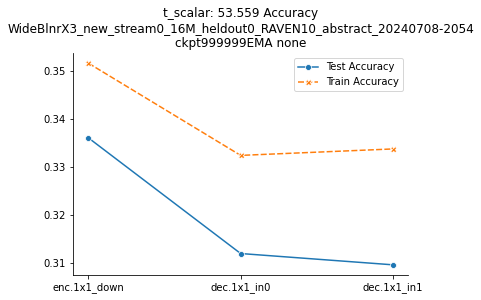

  0%|          | 0/59 [00:00<?, ?it/s]

input torch.Size([120000, 3, 9, 9])
enc.9x9_conv torch.Size([120000, 128, 9, 9])
enc.3x3_down torch.Size([120000, 128, 3, 3])
enc.1x1_down torch.Size([120000, 256, 1, 1])
dec.1x1_in0 torch.Size([120000, 512, 1, 1])
dec.1x1_in1 torch.Size([120000, 512, 1, 1])
dec.3x3_up torch.Size([120000, 512, 1, 1])
dec.9x9_up torch.Size([120000, 256, 7, 7])
dec.9x9_aux_norm torch.Size([120000, 128, 9, 9])
dec.9x9_aux_conv torch.Size([120000, 3, 9, 9])


  0%|          | 0/20 [00:00<?, ?it/s]

input torch.Size([40000, 3, 9, 9])
enc.9x9_conv torch.Size([40000, 128, 9, 9])
enc.3x3_down torch.Size([40000, 128, 3, 3])
enc.1x1_down torch.Size([40000, 256, 1, 1])
dec.1x1_in0 torch.Size([40000, 512, 1, 1])
dec.1x1_in1 torch.Size([40000, 512, 1, 1])
dec.3x3_up torch.Size([40000, 512, 1, 1])
dec.9x9_up torch.Size([40000, 256, 7, 7])
dec.9x9_aux_norm torch.Size([40000, 128, 9, 9])
dec.9x9_aux_conv torch.Size([40000, 3, 9, 9])
Processing layer: enc.1x1_down
Epoch [1/5000], Loss: 3.8521, Accuracy: 0.0227
Epoch [500/5000], Loss: 2.3574, Accuracy: 0.3011
Epoch [1000/5000], Loss: 2.2537, Accuracy: 0.3261
Test Accuracy: 0.3149
Epoch [1500/5000], Loss: 2.1938, Accuracy: 0.3414
Epoch [2000/5000], Loss: 2.1525, Accuracy: 0.3524
Test Accuracy: 0.3382
Epoch [2500/5000], Loss: 2.1218, Accuracy: 0.3602
Epoch [3000/5000], Loss: 2.0978, Accuracy: 0.3661
Test Accuracy: 0.3517
Epoch [3500/5000], Loss: 2.0787, Accuracy: 0.3716
Epoch [4000/5000], Loss: 2.0635, Accuracy: 0.3757
Test Accuracy: 0.3599
Epoc

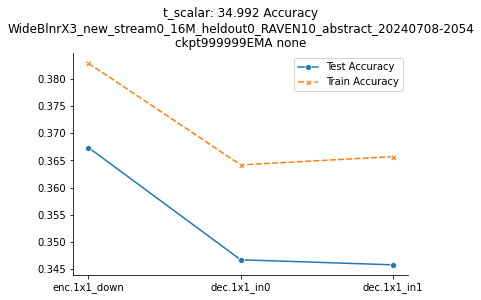

  0%|          | 0/59 [00:00<?, ?it/s]

input torch.Size([120000, 3, 9, 9])
enc.9x9_conv torch.Size([120000, 128, 9, 9])
enc.3x3_down torch.Size([120000, 128, 3, 3])
enc.1x1_down torch.Size([120000, 256, 1, 1])
dec.1x1_in0 torch.Size([120000, 512, 1, 1])
dec.1x1_in1 torch.Size([120000, 512, 1, 1])
dec.3x3_up torch.Size([120000, 512, 1, 1])
dec.9x9_up torch.Size([120000, 256, 7, 7])
dec.9x9_aux_norm torch.Size([120000, 128, 9, 9])
dec.9x9_aux_conv torch.Size([120000, 3, 9, 9])


  0%|          | 0/20 [00:00<?, ?it/s]

input torch.Size([40000, 3, 9, 9])
enc.9x9_conv torch.Size([40000, 128, 9, 9])
enc.3x3_down torch.Size([40000, 128, 3, 3])
enc.1x1_down torch.Size([40000, 256, 1, 1])
dec.1x1_in0 torch.Size([40000, 512, 1, 1])
dec.1x1_in1 torch.Size([40000, 512, 1, 1])
dec.3x3_up torch.Size([40000, 512, 1, 1])
dec.9x9_up torch.Size([40000, 256, 7, 7])
dec.9x9_aux_norm torch.Size([40000, 128, 9, 9])
dec.9x9_aux_conv torch.Size([40000, 3, 9, 9])
Processing layer: enc.1x1_down
Epoch [1/5000], Loss: 3.8114, Accuracy: 0.0262
Epoch [500/5000], Loss: 2.2404, Accuracy: 0.3313
Epoch [1000/5000], Loss: 2.1219, Accuracy: 0.3611
Test Accuracy: 0.3497
Epoch [1500/5000], Loss: 2.0549, Accuracy: 0.3789
Epoch [2000/5000], Loss: 2.0090, Accuracy: 0.3912
Test Accuracy: 0.3770
Epoch [2500/5000], Loss: 1.9755, Accuracy: 0.4003
Epoch [3000/5000], Loss: 1.9501, Accuracy: 0.4071
Test Accuracy: 0.3915
Epoch [3500/5000], Loss: 1.9301, Accuracy: 0.4130
Epoch [4000/5000], Loss: 1.9139, Accuracy: 0.4176
Test Accuracy: 0.3995
Epoc

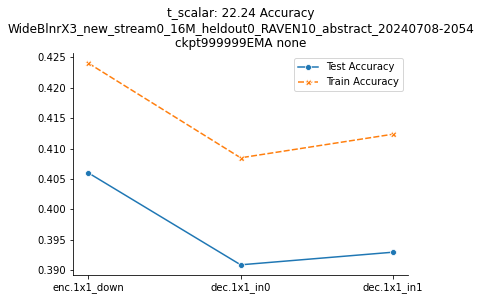

  0%|          | 0/59 [00:00<?, ?it/s]

input torch.Size([120000, 3, 9, 9])
enc.9x9_conv torch.Size([120000, 128, 9, 9])
enc.3x3_down torch.Size([120000, 128, 3, 3])
enc.1x1_down torch.Size([120000, 256, 1, 1])
dec.1x1_in0 torch.Size([120000, 512, 1, 1])
dec.1x1_in1 torch.Size([120000, 512, 1, 1])
dec.3x3_up torch.Size([120000, 512, 1, 1])
dec.9x9_up torch.Size([120000, 256, 7, 7])
dec.9x9_aux_norm torch.Size([120000, 128, 9, 9])
dec.9x9_aux_conv torch.Size([120000, 3, 9, 9])


  0%|          | 0/20 [00:00<?, ?it/s]

input torch.Size([40000, 3, 9, 9])
enc.9x9_conv torch.Size([40000, 128, 9, 9])
enc.3x3_down torch.Size([40000, 128, 3, 3])
enc.1x1_down torch.Size([40000, 256, 1, 1])
dec.1x1_in0 torch.Size([40000, 512, 1, 1])
dec.1x1_in1 torch.Size([40000, 512, 1, 1])
dec.3x3_up torch.Size([40000, 512, 1, 1])
dec.9x9_up torch.Size([40000, 256, 7, 7])
dec.9x9_aux_norm torch.Size([40000, 128, 9, 9])
dec.9x9_aux_conv torch.Size([40000, 3, 9, 9])
Processing layer: enc.1x1_down
Epoch [1/5000], Loss: 3.8262, Accuracy: 0.0241
Epoch [500/5000], Loss: 2.0785, Accuracy: 0.3739
Epoch [1000/5000], Loss: 1.9507, Accuracy: 0.4084
Test Accuracy: 0.3911
Epoch [1500/5000], Loss: 1.8824, Accuracy: 0.4273
Epoch [2000/5000], Loss: 1.8383, Accuracy: 0.4398
Test Accuracy: 0.4200
Epoch [2500/5000], Loss: 1.8078, Accuracy: 0.4478
Epoch [3000/5000], Loss: 1.7848, Accuracy: 0.4550
Test Accuracy: 0.4345
Epoch [3500/5000], Loss: 1.7672, Accuracy: 0.4594
Epoch [4000/5000], Loss: 1.7534, Accuracy: 0.4632
Test Accuracy: 0.4429
Epoc

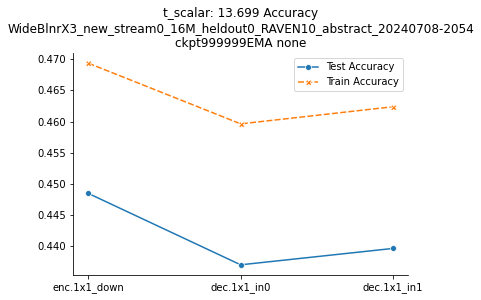

  0%|          | 0/59 [00:00<?, ?it/s]

input torch.Size([120000, 3, 9, 9])
enc.9x9_conv torch.Size([120000, 128, 9, 9])
enc.3x3_down torch.Size([120000, 128, 3, 3])
enc.1x1_down torch.Size([120000, 256, 1, 1])
dec.1x1_in0 torch.Size([120000, 512, 1, 1])
dec.1x1_in1 torch.Size([120000, 512, 1, 1])
dec.3x3_up torch.Size([120000, 512, 1, 1])
dec.9x9_up torch.Size([120000, 256, 7, 7])
dec.9x9_aux_norm torch.Size([120000, 128, 9, 9])
dec.9x9_aux_conv torch.Size([120000, 3, 9, 9])


  0%|          | 0/20 [00:00<?, ?it/s]

input torch.Size([40000, 3, 9, 9])
enc.9x9_conv torch.Size([40000, 128, 9, 9])
enc.3x3_down torch.Size([40000, 128, 3, 3])
enc.1x1_down torch.Size([40000, 256, 1, 1])
dec.1x1_in0 torch.Size([40000, 512, 1, 1])
dec.1x1_in1 torch.Size([40000, 512, 1, 1])
dec.3x3_up torch.Size([40000, 512, 1, 1])
dec.9x9_up torch.Size([40000, 256, 7, 7])
dec.9x9_aux_norm torch.Size([40000, 128, 9, 9])
dec.9x9_aux_conv torch.Size([40000, 3, 9, 9])
Processing layer: enc.1x1_down
Epoch [1/5000], Loss: 3.8978, Accuracy: 0.0218
Epoch [500/5000], Loss: 1.8578, Accuracy: 0.4323
Epoch [1000/5000], Loss: 1.7375, Accuracy: 0.4647
Test Accuracy: 0.4503
Epoch [1500/5000], Loss: 1.6771, Accuracy: 0.4815
Epoch [2000/5000], Loss: 1.6393, Accuracy: 0.4922
Test Accuracy: 0.4763
Epoch [2500/5000], Loss: 1.6133, Accuracy: 0.4999
Epoch [3000/5000], Loss: 1.5943, Accuracy: 0.5060
Test Accuracy: 0.4857
Epoch [3500/5000], Loss: 1.5801, Accuracy: 0.5105
Epoch [4000/5000], Loss: 1.5691, Accuracy: 0.5141
Test Accuracy: 0.4923
Epoc

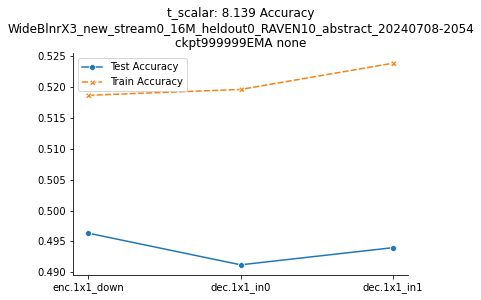

  0%|          | 0/59 [00:00<?, ?it/s]

input torch.Size([120000, 3, 9, 9])
enc.9x9_conv torch.Size([120000, 128, 9, 9])
enc.3x3_down torch.Size([120000, 128, 3, 3])
enc.1x1_down torch.Size([120000, 256, 1, 1])
dec.1x1_in0 torch.Size([120000, 512, 1, 1])
dec.1x1_in1 torch.Size([120000, 512, 1, 1])
dec.3x3_up torch.Size([120000, 512, 1, 1])
dec.9x9_up torch.Size([120000, 256, 7, 7])
dec.9x9_aux_norm torch.Size([120000, 128, 9, 9])
dec.9x9_aux_conv torch.Size([120000, 3, 9, 9])


  0%|          | 0/20 [00:00<?, ?it/s]

input torch.Size([40000, 3, 9, 9])
enc.9x9_conv torch.Size([40000, 128, 9, 9])
enc.3x3_down torch.Size([40000, 128, 3, 3])
enc.1x1_down torch.Size([40000, 256, 1, 1])
dec.1x1_in0 torch.Size([40000, 512, 1, 1])
dec.1x1_in1 torch.Size([40000, 512, 1, 1])
dec.3x3_up torch.Size([40000, 512, 1, 1])
dec.9x9_up torch.Size([40000, 256, 7, 7])
dec.9x9_aux_norm torch.Size([40000, 128, 9, 9])
dec.9x9_aux_conv torch.Size([40000, 3, 9, 9])
Processing layer: enc.1x1_down
Epoch [1/5000], Loss: 3.8359, Accuracy: 0.0220
Epoch [500/5000], Loss: 1.5638, Accuracy: 0.5152
Epoch [1000/5000], Loss: 1.4705, Accuracy: 0.5412
Test Accuracy: 0.5252
Epoch [1500/5000], Loss: 1.4275, Accuracy: 0.5524
Epoch [2000/5000], Loss: 1.4011, Accuracy: 0.5600
Test Accuracy: 0.5403
Epoch [2500/5000], Loss: 1.3829, Accuracy: 0.5659
Epoch [3000/5000], Loss: 1.3696, Accuracy: 0.5689
Test Accuracy: 0.5477
Epoch [3500/5000], Loss: 1.3596, Accuracy: 0.5719
Epoch [4000/5000], Loss: 1.3521, Accuracy: 0.5736
Test Accuracy: 0.5517
Epoc

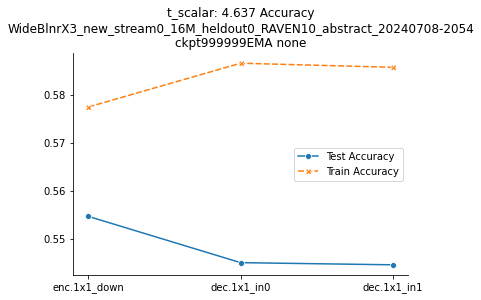

  0%|          | 0/59 [00:00<?, ?it/s]

input torch.Size([120000, 3, 9, 9])
enc.9x9_conv torch.Size([120000, 128, 9, 9])
enc.3x3_down torch.Size([120000, 128, 3, 3])
enc.1x1_down torch.Size([120000, 256, 1, 1])
dec.1x1_in0 torch.Size([120000, 512, 1, 1])
dec.1x1_in1 torch.Size([120000, 512, 1, 1])
dec.3x3_up torch.Size([120000, 512, 1, 1])
dec.9x9_up torch.Size([120000, 256, 7, 7])
dec.9x9_aux_norm torch.Size([120000, 128, 9, 9])
dec.9x9_aux_conv torch.Size([120000, 3, 9, 9])


  0%|          | 0/20 [00:00<?, ?it/s]

input torch.Size([40000, 3, 9, 9])
enc.9x9_conv torch.Size([40000, 128, 9, 9])
enc.3x3_down torch.Size([40000, 128, 3, 3])
enc.1x1_down torch.Size([40000, 256, 1, 1])
dec.1x1_in0 torch.Size([40000, 512, 1, 1])
dec.1x1_in1 torch.Size([40000, 512, 1, 1])
dec.3x3_up torch.Size([40000, 512, 1, 1])
dec.9x9_up torch.Size([40000, 256, 7, 7])
dec.9x9_aux_norm torch.Size([40000, 128, 9, 9])
dec.9x9_aux_conv torch.Size([40000, 3, 9, 9])
Processing layer: enc.1x1_down
Epoch [1/5000], Loss: 3.8475, Accuracy: 0.0264
Epoch [500/5000], Loss: 1.1180, Accuracy: 0.6432
Epoch [1000/5000], Loss: 1.0491, Accuracy: 0.6626
Test Accuracy: 0.6439
Epoch [1500/5000], Loss: 1.0173, Accuracy: 0.6721
Epoch [2000/5000], Loss: 0.9981, Accuracy: 0.6777
Test Accuracy: 0.6573
Epoch [2500/5000], Loss: 0.9852, Accuracy: 0.6817
Epoch [3000/5000], Loss: 0.9759, Accuracy: 0.6840
Test Accuracy: 0.6632
Epoch [3500/5000], Loss: 0.9690, Accuracy: 0.6865
Epoch [4000/5000], Loss: 0.9640, Accuracy: 0.6875
Test Accuracy: 0.6644
Epoc

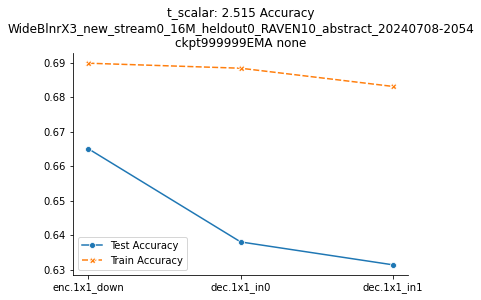

  0%|          | 0/59 [00:00<?, ?it/s]

input torch.Size([120000, 3, 9, 9])
enc.9x9_conv torch.Size([120000, 128, 9, 9])
enc.3x3_down torch.Size([120000, 128, 3, 3])
enc.1x1_down torch.Size([120000, 256, 1, 1])
dec.1x1_in0 torch.Size([120000, 512, 1, 1])
dec.1x1_in1 torch.Size([120000, 512, 1, 1])
dec.3x3_up torch.Size([120000, 512, 1, 1])
dec.9x9_up torch.Size([120000, 256, 7, 7])
dec.9x9_aux_norm torch.Size([120000, 128, 9, 9])
dec.9x9_aux_conv torch.Size([120000, 3, 9, 9])


  0%|          | 0/20 [00:00<?, ?it/s]

input torch.Size([40000, 3, 9, 9])
enc.9x9_conv torch.Size([40000, 128, 9, 9])
enc.3x3_down torch.Size([40000, 128, 3, 3])
enc.1x1_down torch.Size([40000, 256, 1, 1])
dec.1x1_in0 torch.Size([40000, 512, 1, 1])
dec.1x1_in1 torch.Size([40000, 512, 1, 1])
dec.3x3_up torch.Size([40000, 512, 1, 1])
dec.9x9_up torch.Size([40000, 256, 7, 7])
dec.9x9_aux_norm torch.Size([40000, 128, 9, 9])
dec.9x9_aux_conv torch.Size([40000, 3, 9, 9])
Processing layer: enc.1x1_down
Epoch [1/5000], Loss: 3.7983, Accuracy: 0.0252
Epoch [500/5000], Loss: 0.4563, Accuracy: 0.8459
Epoch [1000/5000], Loss: 0.4164, Accuracy: 0.8565
Test Accuracy: 0.8372
Epoch [1500/5000], Loss: 0.3983, Accuracy: 0.8614
Epoch [2000/5000], Loss: 0.3876, Accuracy: 0.8651
Test Accuracy: 0.8425
Epoch [2500/5000], Loss: 0.3803, Accuracy: 0.8671
Epoch [3000/5000], Loss: 0.3751, Accuracy: 0.8685
Test Accuracy: 0.8442
Epoch [3500/5000], Loss: 0.3711, Accuracy: 0.8697
Epoch [4000/5000], Loss: 0.3681, Accuracy: 0.8706
Test Accuracy: 0.8452
Epoc

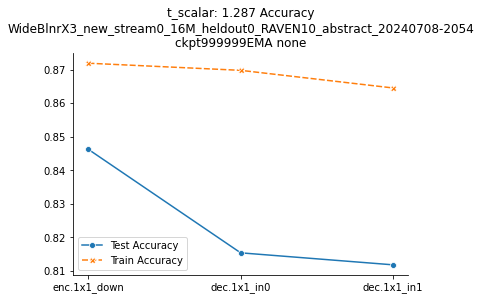

  0%|          | 0/59 [00:00<?, ?it/s]

input torch.Size([120000, 3, 9, 9])
enc.9x9_conv torch.Size([120000, 128, 9, 9])
enc.3x3_down torch.Size([120000, 128, 3, 3])
enc.1x1_down torch.Size([120000, 256, 1, 1])
dec.1x1_in0 torch.Size([120000, 512, 1, 1])
dec.1x1_in1 torch.Size([120000, 512, 1, 1])
dec.3x3_up torch.Size([120000, 512, 1, 1])
dec.9x9_up torch.Size([120000, 256, 7, 7])
dec.9x9_aux_norm torch.Size([120000, 128, 9, 9])
dec.9x9_aux_conv torch.Size([120000, 3, 9, 9])


  0%|          | 0/20 [00:00<?, ?it/s]

input torch.Size([40000, 3, 9, 9])
enc.9x9_conv torch.Size([40000, 128, 9, 9])
enc.3x3_down torch.Size([40000, 128, 3, 3])
enc.1x1_down torch.Size([40000, 256, 1, 1])
dec.1x1_in0 torch.Size([40000, 512, 1, 1])
dec.1x1_in1 torch.Size([40000, 512, 1, 1])
dec.3x3_up torch.Size([40000, 512, 1, 1])
dec.9x9_up torch.Size([40000, 256, 7, 7])
dec.9x9_aux_norm torch.Size([40000, 128, 9, 9])
dec.9x9_aux_conv torch.Size([40000, 3, 9, 9])
Processing layer: enc.1x1_down
Epoch [1/5000], Loss: 3.8211, Accuracy: 0.0347
Epoch [500/5000], Loss: 0.2175, Accuracy: 0.9223
Epoch [1000/5000], Loss: 0.1967, Accuracy: 0.9281
Test Accuracy: 0.9106
Epoch [1500/5000], Loss: 0.1871, Accuracy: 0.9306
Epoch [2000/5000], Loss: 0.1811, Accuracy: 0.9319
Test Accuracy: 0.9123
Epoch [2500/5000], Loss: 0.1769, Accuracy: 0.9333
Epoch [3000/5000], Loss: 0.1736, Accuracy: 0.9344
Test Accuracy: 0.9123
Epoch [3500/5000], Loss: 0.1710, Accuracy: 0.9353
Epoch [4000/5000], Loss: 0.1688, Accuracy: 0.9362
Test Accuracy: 0.9120
Epoc

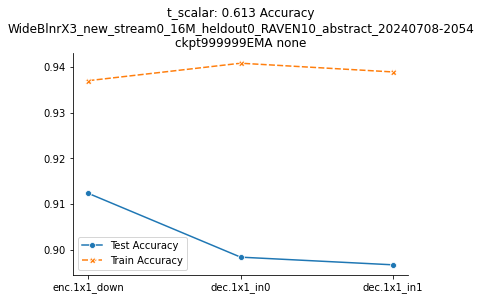

  0%|          | 0/59 [00:00<?, ?it/s]

input torch.Size([120000, 3, 9, 9])
enc.9x9_conv torch.Size([120000, 128, 9, 9])
enc.3x3_down torch.Size([120000, 128, 3, 3])
enc.1x1_down torch.Size([120000, 256, 1, 1])
dec.1x1_in0 torch.Size([120000, 512, 1, 1])
dec.1x1_in1 torch.Size([120000, 512, 1, 1])
dec.3x3_up torch.Size([120000, 512, 1, 1])
dec.9x9_up torch.Size([120000, 256, 7, 7])
dec.9x9_aux_norm torch.Size([120000, 128, 9, 9])
dec.9x9_aux_conv torch.Size([120000, 3, 9, 9])


  0%|          | 0/20 [00:00<?, ?it/s]

input torch.Size([40000, 3, 9, 9])
enc.9x9_conv torch.Size([40000, 128, 9, 9])
enc.3x3_down torch.Size([40000, 128, 3, 3])
enc.1x1_down torch.Size([40000, 256, 1, 1])
dec.1x1_in0 torch.Size([40000, 512, 1, 1])
dec.1x1_in1 torch.Size([40000, 512, 1, 1])
dec.3x3_up torch.Size([40000, 512, 1, 1])
dec.9x9_up torch.Size([40000, 256, 7, 7])
dec.9x9_aux_norm torch.Size([40000, 128, 9, 9])
dec.9x9_aux_conv torch.Size([40000, 3, 9, 9])
Processing layer: enc.1x1_down
Epoch [1/5000], Loss: 3.9734, Accuracy: 0.0109
Epoch [500/5000], Loss: 0.1542, Accuracy: 0.9433
Epoch [1000/5000], Loss: 0.1385, Accuracy: 0.9477
Test Accuracy: 0.9347
Epoch [1500/5000], Loss: 0.1314, Accuracy: 0.9496
Epoch [2000/5000], Loss: 0.1270, Accuracy: 0.9512
Test Accuracy: 0.9359
Epoch [2500/5000], Loss: 0.1240, Accuracy: 0.9521
Epoch [3000/5000], Loss: 0.1217, Accuracy: 0.9525
Test Accuracy: 0.9357
Epoch [3500/5000], Loss: 0.1199, Accuracy: 0.9527
Epoch [4000/5000], Loss: 0.1185, Accuracy: 0.9530
Test Accuracy: 0.9354
Epoc

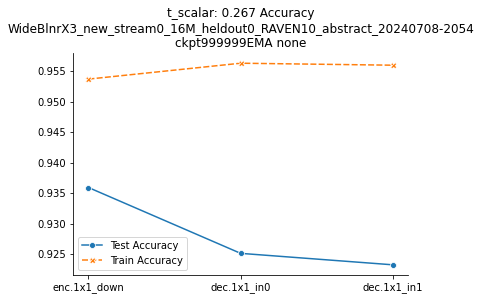

  0%|          | 0/59 [00:00<?, ?it/s]

input torch.Size([120000, 3, 9, 9])
enc.9x9_conv torch.Size([120000, 128, 9, 9])
enc.3x3_down torch.Size([120000, 128, 3, 3])
enc.1x1_down torch.Size([120000, 256, 1, 1])
dec.1x1_in0 torch.Size([120000, 512, 1, 1])
dec.1x1_in1 torch.Size([120000, 512, 1, 1])
dec.3x3_up torch.Size([120000, 512, 1, 1])
dec.9x9_up torch.Size([120000, 256, 7, 7])
dec.9x9_aux_norm torch.Size([120000, 128, 9, 9])
dec.9x9_aux_conv torch.Size([120000, 3, 9, 9])


  0%|          | 0/20 [00:00<?, ?it/s]

input torch.Size([40000, 3, 9, 9])
enc.9x9_conv torch.Size([40000, 128, 9, 9])
enc.3x3_down torch.Size([40000, 128, 3, 3])
enc.1x1_down torch.Size([40000, 256, 1, 1])
dec.1x1_in0 torch.Size([40000, 512, 1, 1])
dec.1x1_in1 torch.Size([40000, 512, 1, 1])
dec.3x3_up torch.Size([40000, 512, 1, 1])
dec.9x9_up torch.Size([40000, 256, 7, 7])
dec.9x9_aux_norm torch.Size([40000, 128, 9, 9])
dec.9x9_aux_conv torch.Size([40000, 3, 9, 9])
Processing layer: enc.1x1_down
Epoch [1/5000], Loss: 3.7529, Accuracy: 0.0331
Epoch [500/5000], Loss: 0.1700, Accuracy: 0.9380
Epoch [1000/5000], Loss: 0.1506, Accuracy: 0.9436
Test Accuracy: 0.9301
Epoch [1500/5000], Loss: 0.1415, Accuracy: 0.9462
Epoch [2000/5000], Loss: 0.1358, Accuracy: 0.9478
Test Accuracy: 0.9310
Epoch [2500/5000], Loss: 0.1317, Accuracy: 0.9491
Epoch [3000/5000], Loss: 0.1286, Accuracy: 0.9501
Test Accuracy: 0.9318
Epoch [3500/5000], Loss: 0.1260, Accuracy: 0.9509
Epoch [4000/5000], Loss: 0.1239, Accuracy: 0.9516
Test Accuracy: 0.9321
Epoc

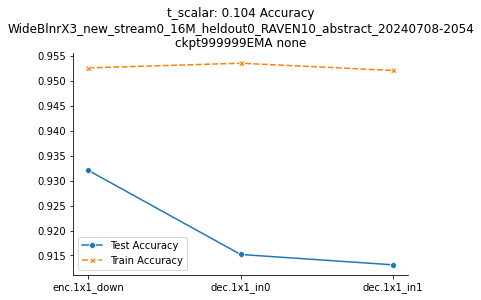

  0%|          | 0/59 [00:00<?, ?it/s]

input torch.Size([120000, 3, 9, 9])
enc.9x9_conv torch.Size([120000, 128, 9, 9])
enc.3x3_down torch.Size([120000, 128, 3, 3])
enc.1x1_down torch.Size([120000, 256, 1, 1])
dec.1x1_in0 torch.Size([120000, 512, 1, 1])
dec.1x1_in1 torch.Size([120000, 512, 1, 1])
dec.3x3_up torch.Size([120000, 512, 1, 1])
dec.9x9_up torch.Size([120000, 256, 7, 7])
dec.9x9_aux_norm torch.Size([120000, 128, 9, 9])
dec.9x9_aux_conv torch.Size([120000, 3, 9, 9])


  0%|          | 0/20 [00:00<?, ?it/s]

input torch.Size([40000, 3, 9, 9])
enc.9x9_conv torch.Size([40000, 128, 9, 9])
enc.3x3_down torch.Size([40000, 128, 3, 3])
enc.1x1_down torch.Size([40000, 256, 1, 1])
dec.1x1_in0 torch.Size([40000, 512, 1, 1])
dec.1x1_in1 torch.Size([40000, 512, 1, 1])
dec.3x3_up torch.Size([40000, 512, 1, 1])
dec.9x9_up torch.Size([40000, 256, 7, 7])
dec.9x9_aux_norm torch.Size([40000, 128, 9, 9])
dec.9x9_aux_conv torch.Size([40000, 3, 9, 9])
Processing layer: enc.1x1_down
Epoch [1/5000], Loss: 3.8019, Accuracy: 0.0303
Epoch [500/5000], Loss: 0.2271, Accuracy: 0.9182
Epoch [1000/5000], Loss: 0.2004, Accuracy: 0.9261
Test Accuracy: 0.9103
Epoch [1500/5000], Loss: 0.1877, Accuracy: 0.9298
Epoch [2000/5000], Loss: 0.1796, Accuracy: 0.9326
Test Accuracy: 0.9147
Epoch [2500/5000], Loss: 0.1738, Accuracy: 0.9347
Epoch [3000/5000], Loss: 0.1694, Accuracy: 0.9363
Test Accuracy: 0.9151
Epoch [3500/5000], Loss: 0.1658, Accuracy: 0.9373
Epoch [4000/5000], Loss: 0.1629, Accuracy: 0.9382
Test Accuracy: 0.9147
Epoc

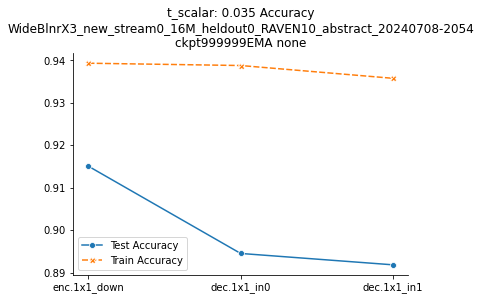

  0%|          | 0/59 [00:00<?, ?it/s]

input torch.Size([120000, 3, 9, 9])
enc.9x9_conv torch.Size([120000, 128, 9, 9])
enc.3x3_down torch.Size([120000, 128, 3, 3])
enc.1x1_down torch.Size([120000, 256, 1, 1])
dec.1x1_in0 torch.Size([120000, 512, 1, 1])
dec.1x1_in1 torch.Size([120000, 512, 1, 1])
dec.3x3_up torch.Size([120000, 512, 1, 1])
dec.9x9_up torch.Size([120000, 256, 7, 7])
dec.9x9_aux_norm torch.Size([120000, 128, 9, 9])
dec.9x9_aux_conv torch.Size([120000, 3, 9, 9])


  0%|          | 0/20 [00:00<?, ?it/s]

input torch.Size([40000, 3, 9, 9])
enc.9x9_conv torch.Size([40000, 128, 9, 9])
enc.3x3_down torch.Size([40000, 128, 3, 3])
enc.1x1_down torch.Size([40000, 256, 1, 1])
dec.1x1_in0 torch.Size([40000, 512, 1, 1])
dec.1x1_in1 torch.Size([40000, 512, 1, 1])
dec.3x3_up torch.Size([40000, 512, 1, 1])
dec.9x9_up torch.Size([40000, 256, 7, 7])
dec.9x9_aux_norm torch.Size([40000, 128, 9, 9])
dec.9x9_aux_conv torch.Size([40000, 3, 9, 9])
Processing layer: enc.1x1_down
Epoch [1/5000], Loss: 3.8753, Accuracy: 0.0207
Epoch [500/5000], Loss: 0.2573, Accuracy: 0.9082
Epoch [1000/5000], Loss: 0.2263, Accuracy: 0.9176
Test Accuracy: 0.9002
Epoch [1500/5000], Loss: 0.2116, Accuracy: 0.9221
Epoch [2000/5000], Loss: 0.2022, Accuracy: 0.9251
Test Accuracy: 0.9042
Epoch [2500/5000], Loss: 0.1955, Accuracy: 0.9273
Epoch [3000/5000], Loss: 0.1903, Accuracy: 0.9289
Test Accuracy: 0.9052
Epoch [3500/5000], Loss: 0.1862, Accuracy: 0.9301
Epoch [4000/5000], Loss: 0.1828, Accuracy: 0.9311
Test Accuracy: 0.9055
Epoc

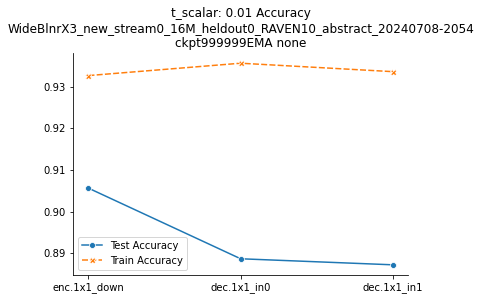

  0%|          | 0/59 [00:00<?, ?it/s]

input torch.Size([120000, 3, 9, 9])
enc.9x9_conv torch.Size([120000, 128, 9, 9])
enc.3x3_down torch.Size([120000, 128, 3, 3])
enc.1x1_down torch.Size([120000, 256, 1, 1])
dec.1x1_in0 torch.Size([120000, 512, 1, 1])
dec.1x1_in1 torch.Size([120000, 512, 1, 1])
dec.3x3_up torch.Size([120000, 512, 1, 1])
dec.9x9_up torch.Size([120000, 256, 7, 7])
dec.9x9_aux_norm torch.Size([120000, 128, 9, 9])
dec.9x9_aux_conv torch.Size([120000, 3, 9, 9])


  0%|          | 0/20 [00:00<?, ?it/s]

input torch.Size([40000, 3, 9, 9])
enc.9x9_conv torch.Size([40000, 128, 9, 9])
enc.3x3_down torch.Size([40000, 128, 3, 3])
enc.1x1_down torch.Size([40000, 256, 1, 1])
dec.1x1_in0 torch.Size([40000, 512, 1, 1])
dec.1x1_in1 torch.Size([40000, 512, 1, 1])
dec.3x3_up torch.Size([40000, 512, 1, 1])
dec.9x9_up torch.Size([40000, 256, 7, 7])
dec.9x9_aux_norm torch.Size([40000, 128, 9, 9])
dec.9x9_aux_conv torch.Size([40000, 3, 9, 9])
Processing layer: enc.1x1_down
Epoch [1/5000], Loss: 3.8590, Accuracy: 0.0273
Epoch [500/5000], Loss: 0.2774, Accuracy: 0.9019
Epoch [1000/5000], Loss: 0.2421, Accuracy: 0.9128
Test Accuracy: 0.8963
Epoch [1500/5000], Loss: 0.2255, Accuracy: 0.9181
Epoch [2000/5000], Loss: 0.2151, Accuracy: 0.9212
Test Accuracy: 0.9001
Epoch [2500/5000], Loss: 0.2076, Accuracy: 0.9230
Epoch [3000/5000], Loss: 0.2019, Accuracy: 0.9248
Test Accuracy: 0.9008
Epoch [3500/5000], Loss: 0.1972, Accuracy: 0.9263
Epoch [4000/5000], Loss: 0.1934, Accuracy: 0.9274
Test Accuracy: 0.9013
Epoc

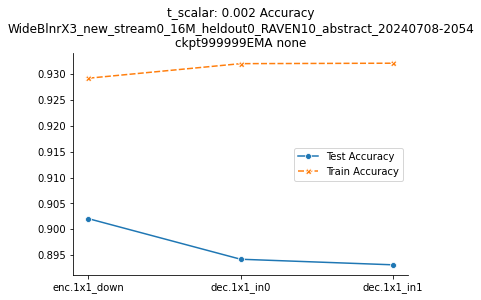

In [101]:
fetcher = featureFetcher_module()
record_module_list = ["input",
               'enc.9x9_conv',
                'enc.3x3_down',
                'enc.1x1_down',
                'dec.1x1_in0',
                'dec.1x1_in1',
                'dec.3x3_up',
                'dec.9x9_up',
                # 'dec.9x9_block2',
                "dec.9x9_aux_norm",
                "dec.9x9_aux_conv", ]
for blockname in list(edm.ema.enc):
    if f"enc.{blockname}" in record_module_list:
        fetcher.record_module(edm.ema.enc[blockname], target_name=f"enc.{blockname}")
for blockname in list(edm.ema.dec):
    if f"dec.{blockname}" in record_module_list:
        fetcher.record_module(edm.ema.dec[blockname], target_name=f"dec.{blockname}")
# Now use the function for both training and testing data
train_loader = DataLoader(train_dataset, batch_size=2048, shuffle=False, drop_last=False)
test_loader = DataLoader(test_dataset, batch_size=2048, shuffle=False, drop_last=False)

dimred_str = "none"
ckpt_str = "ckpt999999EMA"
sigma_list = [80.000, 53.559, 34.992, 22.240, 13.699, 8.139, 4.637, 2.515, 1.287, 0.613, 0.267, 0.104, 0.035, 0.010, 0.002]
for t_scalar in sigma_list:
    t_str = str(t_scalar).replace('.', '_')
    feature_col = extract_features_EDM(edm, fetcher, train_loader, dataset_Xmean, dataset_Xstd, t_scalar)
    feature_col_test = extract_features_EDM(edm, fetcher, test_loader, dataset_Xmean, dataset_Xstd, t_scalar)
    feature_avg_col = {k: v.mean(dim=(2,3)) for k, v in feature_col.items()}
    feature_avg_col_test = {k: v.mean(dim=(2,3)) for k, v in feature_col_test.items()}
    feature_sel_col = {k: v for k, v in feature_col.items() if "1x1" in k}
    feature_sel_col_test = {k: v for k, v in feature_col_test.items() if "1x1" in k}
    model_PCA_col, PC_proj_col, results_col = train_pca_sgd_classifiers(
        feature_sel_col, feature_sel_col_test, y_train, y_test,
        PC_dim=1024, noPCA=True, num_classes=40, batch_size=None,
        num_epochs=5000, print_every=500, eval_every=1000, learning_rate=0.005,
        device='cuda'
    )
    pkl.dump(results_col, open(join(repr_expdir,f"results_col_t{t_str}_{dimred_str}_{ckpt_str}.pkl"), "wb"))
    pkl.dump(PC_proj_col, open(join(repr_expdir,f"PC_proj_col_t{t_str}_{dimred_str}_{ckpt_str}.pkl"), "wb"))
    pkl.dump(model_PCA_col, open(join(repr_expdir,f"model_PCA_col_t{t_str}_{dimred_str}_{ckpt_str}.pkl"), "wb"))

    test_acc_synopsis = {key: results_col[key].test_record.accuracy.max() for key in results_col.keys()}
    train_acc_synopsis = {key: results_col[key].train_record.accuracy.max() for key in results_col.keys()}
    syn_df = pd.DataFrame([test_acc_synopsis, train_acc_synopsis]).T
    syn_df.columns = ["Test Accuracy", "Train Accuracy"]
    plt.figure(figsize=(6, 4))
    sns.lineplot(data=syn_df, markers=True)
    plt.title(f"t_scalar: {t_scalar} Accuracy\n{expname}\n{ckpt_str} {dimred_str}")
    saveallforms([repr_expdir,],f"t{t_str}_{dimred_str}_{ckpt_str}_accuracy.png")
    plt.show()

In [107]:
!ls {repr_expdir}

model_PCA_col_t0_002_none_ckpt999999EMA.pkl
model_PCA_col_t0_01_none_ckpt999999EMA.pkl
model_PCA_col_t0_035_none_ckpt999999EMA.pkl
model_PCA_col_t0_104_none_ckpt999999EMA.pkl
model_PCA_col_t0_267_none_ckpt999999EMA.pkl
model_PCA_col_t0_35_none_ckpt999999EMA.pkl
model_PCA_col_t0_613_none_ckpt999999EMA.pkl
model_PCA_col_t1_287_none_ckpt999999EMA.pkl
model_PCA_col_t13_699_none_ckpt999999EMA.pkl
model_PCA_col_t22_24_none_ckpt999999EMA.pkl
model_PCA_col_t2_515_none_ckpt999999EMA.pkl
model_PCA_col_t34_992_none_ckpt999999EMA.pkl
model_PCA_col_t4_637_none_ckpt999999EMA.pkl
model_PCA_col_t53_559_none_ckpt999999EMA.pkl
model_PCA_col_t80_0_none_ckpt999999EMA.pkl
model_PCA_col_t8_139_none_ckpt999999EMA.pkl
PC_proj_col_t0_002_none_ckpt999999EMA.pkl
PC_proj_col_t0_01_none_ckpt999999EMA.pkl
PC_proj_col_t0_035_none_ckpt999999EMA.pkl
PC_proj_col_t0_104_none_ckpt999999EMA.pkl
PC_proj_col_t0_267_none_ckpt999999EMA.pkl
PC_proj_col_t0_35_none_ckpt999999EMA.pkl
PC_proj_col_t0_613_none_ckpt999999EMA.pkl
PC_p

In [112]:
def sweep_classifier_result(repr_dir, t_list=[0, 1, 10, 25, 50, 100, 250, 500, 1000], 
                            epoch_list=[-1, 20000, 100000, 200000, 500000, 700000, 1000000 ],
                            dimred_strs=["pca384", "avgtoken"], use_ema=False):
    syn_df_all = []
    # t_scalar = 0.1
    for t_scalar in t_list:
        for epoch in epoch_list:
            t_str = str(t_scalar).replace(".", "_")
            for dimred_str in dimred_strs:
                ckpt_str = "RNDINIT" if epoch == -1 else \
                           f"{epoch}{'EMA' if use_ema else ''}"
                try:
                    results_col = pkl.load(open(join(repr_dir, f"results_col_t{t_str}_{dimred_str}_ckpt{ckpt_str}.pkl"), "rb"))
                except FileNotFoundError:
                    print(f"File not found: {repr_dir}/results_col_t{t_str}_{dimred_str}_ckpt{ckpt_str}.pkl")
                    continue
                test_acc_synopsis = {key: results_col[key].test_acc for key in results_col.keys()}
                train_acc_synopsis = {key: results_col[key].train_record.accuracy.max() for key in results_col.keys()}
                syn_df = pd.DataFrame([test_acc_synopsis, train_acc_synopsis]).T
                syn_df.columns = ["Test Accuracy", "Train Accuracy"]
                syn_df["t"] = t_scalar
                syn_df["epoch"] = epoch
                syn_df["dimred"] = dimred_str
                # drop index as layer name
                syn_df = syn_df.reset_index()
                syn_df = syn_df.rename(columns={"index": "Layer"})
                syn_df_all.append(syn_df)
        
    syn_df_all = pd.concat(syn_df_all, axis=0)
    syn_df_all = syn_df_all.reset_index(drop=True)
    return syn_df_all

In [128]:
synroot = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Figures/DiffusionReasoning/Figure_repr_linear_probe"
figexpdir = join(synroot,expname)
os.makedirs(figexpdir)

In [113]:
syn_df_all = sweep_classifier_result(repr_expdir, t_list=[80.000, 53.559, 34.992, 22.240, 13.699, 8.139, 4.637, 2.515, 1.287, 0.613, 0.267, 0.104, 0.035, 0.010, 0.002], epoch_list=[999999], dimred_strs=["none"],use_ema=True)
syn_df_all.to_csv(join(repr_expdir, "pilot_classifier_acc_time_scaling_999999EMA.csv"))

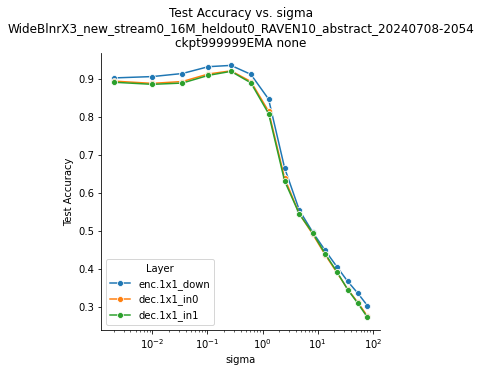

In [129]:
plt.figure(figsize=(5, 5))
sns.lineplot(syn_df_all, x="t", y="Test Accuracy", hue="Layer", marker="o")
plt.xscale("log")
plt.xlabel("sigma")
plt.title(f"Test Accuracy vs. sigma\n{expname}\n{ckpt_str} {dimred_str}")
saveallforms([figexpdir,],f"acc_difftime_curve_{dimred_str}_{ckpt_str}_accuracy")
plt.show()

In [123]:
[*reversed([80.0, 40.0, 13.7, 4.6, 2.5, 1.3, 1.0, 0.8, 0.6, 0.3, 0.2, 0.10, 0.035, 0.010, 0.002])]

[0.002,
 0.01,
 0.035,
 0.1,
 0.2,
 0.3,
 0.6,
 0.8,
 1.0,
 1.3,
 2.5,
 4.6,
 13.7,
 40.0,
 80.0]

In [ ]:
[0.002, 0.01, 0.035, 0.1, 0.2, 0.3, 0.6, 0.8, 1.0, 1.3, 2.5, 4.6, 13.7, 40.0, 80.0]

### Dense sampling of layers at single time point

  0%|          | 0/59 [00:00<?, ?it/s]

input torch.Size([120000, 3, 9, 9])
enc.9x9_conv torch.Size([120000, 128, 9, 9])
enc.9x9_block0 torch.Size([120000, 128, 9, 9])
enc.9x9_block1 torch.Size([120000, 128, 9, 9])
enc.3x3_down torch.Size([120000, 128, 3, 3])
enc.3x3_block0 torch.Size([120000, 256, 3, 3])
enc.3x3_block1 torch.Size([120000, 256, 3, 3])
enc.1x1_down torch.Size([120000, 256, 1, 1])
enc.1x1_block0 torch.Size([120000, 512, 1, 1])
enc.1x1_block1 torch.Size([120000, 512, 1, 1])
dec.1x1_in0 torch.Size([120000, 512, 1, 1])
dec.1x1_in1 torch.Size([120000, 512, 1, 1])
dec.1x1_block0 torch.Size([120000, 512, 1, 1])
dec.1x1_block1 torch.Size([120000, 512, 1, 1])
dec.1x1_block2 torch.Size([120000, 512, 1, 1])
dec.3x3_up torch.Size([120000, 512, 1, 1])
dec.3x3_block0 torch.Size([120000, 256, 3, 3])
dec.3x3_block1 torch.Size([120000, 256, 3, 3])
dec.3x3_block2 torch.Size([120000, 256, 3, 3])
dec.9x9_up torch.Size([120000, 256, 7, 7])
dec.9x9_block0 torch.Size([120000, 128, 9, 9])
dec.9x9_block1 torch.Size([120000, 128, 9, 9

  0%|          | 0/20 [00:00<?, ?it/s]

input torch.Size([40000, 3, 9, 9])
enc.9x9_conv torch.Size([40000, 128, 9, 9])
enc.9x9_block0 torch.Size([40000, 128, 9, 9])
enc.9x9_block1 torch.Size([40000, 128, 9, 9])
enc.3x3_down torch.Size([40000, 128, 3, 3])
enc.3x3_block0 torch.Size([40000, 256, 3, 3])
enc.3x3_block1 torch.Size([40000, 256, 3, 3])
enc.1x1_down torch.Size([40000, 256, 1, 1])
enc.1x1_block0 torch.Size([40000, 512, 1, 1])
enc.1x1_block1 torch.Size([40000, 512, 1, 1])
dec.1x1_in0 torch.Size([40000, 512, 1, 1])
dec.1x1_in1 torch.Size([40000, 512, 1, 1])
dec.1x1_block0 torch.Size([40000, 512, 1, 1])
dec.1x1_block1 torch.Size([40000, 512, 1, 1])
dec.1x1_block2 torch.Size([40000, 512, 1, 1])
dec.3x3_up torch.Size([40000, 512, 1, 1])
dec.3x3_block0 torch.Size([40000, 256, 3, 3])
dec.3x3_block1 torch.Size([40000, 256, 3, 3])
dec.3x3_block2 torch.Size([40000, 256, 3, 3])
dec.9x9_up torch.Size([40000, 256, 7, 7])
dec.9x9_block0 torch.Size([40000, 128, 9, 9])
dec.9x9_block1 torch.Size([40000, 128, 9, 9])
dec.9x9_block2 torc

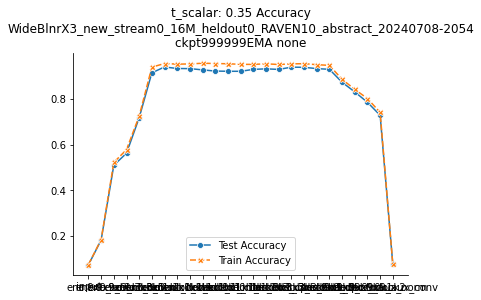

In [104]:
fetcher = featureFetcher_module()
# record_module_list = ["input",
#                'enc.9x9_conv',
#                 'enc.3x3_down',
#                 'enc.1x1_down',
#                 'dec.1x1_in0',
#                 'dec.1x1_in1',
#                 'dec.3x3_up',
#                 'dec.9x9_up',
#                 # 'dec.9x9_block2',
#                 "dec.9x9_aux_norm",
#                 "dec.9x9_aux_conv", ]
for blockname in list(edm.ema.enc):
    # if f"enc.{blockname}" in record_module_list:
    fetcher.record_module(edm.ema.enc[blockname], target_name=f"enc.{blockname}")
for blockname in list(edm.ema.dec):
    # if f"dec.{blockname}" in record_module_list:
    fetcher.record_module(edm.ema.dec[blockname], target_name=f"dec.{blockname}")
# Now use the function for both training and testing data
train_loader = DataLoader(train_dataset, batch_size=2048, shuffle=False, drop_last=False)
test_loader = DataLoader(test_dataset, batch_size=2048, shuffle=False, drop_last=False)

dimred_str = "none"
ckpt_str = "ckpt999999EMA"
sigma_list = [0.35] #[80.000, 53.559, 34.992, 22.240, 13.699, 8.139, 4.637, 2.515, 1.287, 0.613, 0.267, 0.104, 0.035, 0.010, 0.002]
for t_scalar in sigma_list:
    t_str = str(t_scalar).replace('.', '_')
    feature_col = extract_features_EDM(edm, fetcher, train_loader, dataset_Xmean, dataset_Xstd, t_scalar)
    feature_col_test = extract_features_EDM(edm, fetcher, test_loader, dataset_Xmean, dataset_Xstd, t_scalar)
    feature_avg_col = {k: v.mean(dim=(2,3)) for k, v in feature_col.items()}
    feature_avg_col_test = {k: v.mean(dim=(2,3)) for k, v in feature_col_test.items()}
    # feature_sel_col = {k: v for k, v in feature_col.items() if "1x1" in k}
    # feature_sel_col_test = {k: v for k, v in feature_col_test.items() if "1x1" in k}
    model_PCA_col, PC_proj_col, results_col = train_pca_sgd_classifiers(
        feature_avg_col, feature_avg_col_test, y_train, y_test,
        PC_dim=1024, noPCA=True, num_classes=40, batch_size=None,
        num_epochs=5000, print_every=500, eval_every=1000, learning_rate=0.005,
        device='cuda'
    )
    pkl.dump(results_col, open(join(repr_expdir,f"results_col_t{t_str}_{dimred_str}_{ckpt_str}.pkl"), "wb"))
    pkl.dump(PC_proj_col, open(join(repr_expdir,f"PC_proj_col_t{t_str}_{dimred_str}_{ckpt_str}.pkl"), "wb"))
    pkl.dump(model_PCA_col, open(join(repr_expdir,f"model_PCA_col_t{t_str}_{dimred_str}_{ckpt_str}.pkl"), "wb"))

    test_acc_synopsis = {key: results_col[key].test_record.accuracy.max() for key in results_col.keys()}
    train_acc_synopsis = {key: results_col[key].train_record.accuracy.max() for key in results_col.keys()}
    syn_df = pd.DataFrame([test_acc_synopsis, train_acc_synopsis]).T
    syn_df.columns = ["Test Accuracy", "Train Accuracy"]
    plt.figure(figsize=(6, 4))
    sns.lineplot(data=syn_df, markers=True)
    plt.title(f"t_scalar: {t_scalar} Accuracy\n{expname}\n{ckpt_str} {dimred_str}")
    saveallforms([repr_expdir,],f"t{t_str}_{dimred_str}_{ckpt_str}_accuracy.png")
    plt.show()

In [130]:
syn_df_all_dense = sweep_classifier_result(repr_expdir, t_list=[0.35], epoch_list=[999999], dimred_strs=["none"],use_ema=True)
syn_df_all_dense.to_csv(join(repr_expdir, "pilot_classifier_acc_layer_999999EMA.csv"))

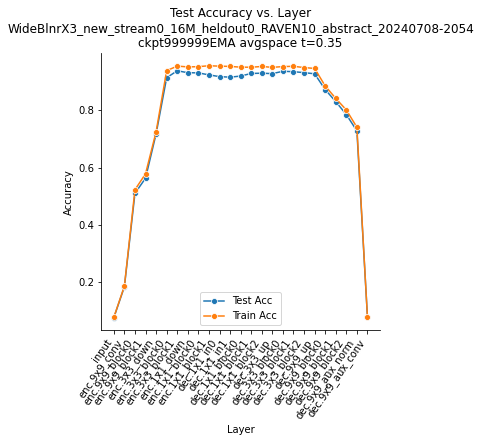

In [143]:
dimred_str = 'avgspace'
plt.figure(figsize=(5, 5))
sns.lineplot(syn_df_all_dense, x="Layer", y="Test Accuracy", marker="o",  label="Test Acc", ) #label="Test Acc",
sns.lineplot(syn_df_all_dense, x="Layer", y="Train Accuracy", marker="o", label="Train Acc", ) #label="Train Acc",
# plt.xscale("log")
# plt.xlabel("sigma")
# rotate x ticks
plt.ylabel("Accuracy")
plt.legend()
plt.xticks(rotation=55, ha='right')
plt.title(f"Test Accuracy vs. Layer\n{expname}\n{ckpt_str} {dimred_str} t=0.35")
saveallforms([figexpdir,],f"acc_layerdepth_curve_{dimred_str}_{ckpt_str}_accuracy")
plt.show()

In [144]:
syn_df_all_dense

,Layer,Test Accuracy,Train Accuracy,t,epoch,dimred
0,input,0.075425,0.076783,0.35,999999,none
1,enc.9x9_conv,0.183600,0.185900,0.35,999999,none
2,enc.9x9_block0,0.510275,0.522733,0.35,999999,none
3,enc.9x9_block1,0.562850,0.578250,0.35,999999,none
4,enc.3x3_down,0.717875,0.725158,0.35,999999,none
5,enc.3x3_block0,0.914075,0.938692,0.35,999999,none
6,enc.3x3_block1,0.938275,0.954617,0.35,999999,none
7,enc.1x1_down,0.931625,0.951825,0.35,999999,none
8,enc.1x1_block0,0.930900,0.952675,0.35,999999,none
9,enc.1x1_block1,0.923975,0.955900,0.35,999999,none


In [106]:
for layer in feature_col:
    print(layer, feature_col[layer].shape)

input torch.Size([120000, 3, 9, 9])
enc.9x9_conv torch.Size([120000, 128, 9, 9])
enc.9x9_block0 torch.Size([120000, 128, 9, 9])
enc.9x9_block1 torch.Size([120000, 128, 9, 9])
enc.3x3_down torch.Size([120000, 128, 3, 3])
enc.3x3_block0 torch.Size([120000, 256, 3, 3])
enc.3x3_block1 torch.Size([120000, 256, 3, 3])
enc.1x1_down torch.Size([120000, 256, 1, 1])
enc.1x1_block0 torch.Size([120000, 512, 1, 1])
enc.1x1_block1 torch.Size([120000, 512, 1, 1])
dec.1x1_in0 torch.Size([120000, 512, 1, 1])
dec.1x1_in1 torch.Size([120000, 512, 1, 1])
dec.1x1_block0 torch.Size([120000, 512, 1, 1])
dec.1x1_block1 torch.Size([120000, 512, 1, 1])
dec.1x1_block2 torch.Size([120000, 512, 1, 1])
dec.3x3_up torch.Size([120000, 512, 1, 1])
dec.3x3_block0 torch.Size([120000, 256, 3, 3])
dec.3x3_block1 torch.Size([120000, 256, 3, 3])
dec.3x3_block2 torch.Size([120000, 256, 3, 3])
dec.9x9_up torch.Size([120000, 256, 7, 7])
dec.9x9_block0 torch.Size([120000, 128, 9, 9])
dec.9x9_block1 torch.Size([120000, 128, 9, 9

### Scratch

In [24]:
# layerkey = "blocks.11"
# fetcher = featureFetcher_module()
# for i in [0,2,5,8,11]: #range(12):
#     fetcher.record_module(model.blocks[i], target_name=f"blocks.{i}")
if False:
    train_loader = DataLoader(train_dataset, batch_size=2048, shuffle=False, drop_last=False)
    test_loader = DataLoader(test_dataset, batch_size=2048, shuffle=False, drop_last=False)
    t_scalar = 0.1
    feature_col = defaultdict(list)
    for X_batch, y_batch in tqdm(train_loader):
        # model_kwargs = dict(y=th.zeros(X_batch.shape[0], dtype=torch.int, device="cuda"))
        t_vec = th.ones(X_batch.shape[0], dtype=torch.float, device="cuda") * t_scalar
        X_batch_norm = (X_batch.cuda().float() - dataset_Xmean) / dataset_Xstd
        with th.no_grad():
            model_EDM(X_batch_norm, t_vec, None)
        feature_col["input"].append(X_batch.float())
        for key, activations in fetcher.activations.items():
            feature_col[key].append(activations)
    for key in feature_col.keys():
        feature_col[key] = th.cat(feature_col[key], dim=0)
        print(key, feature_col[key].shape)


    feature_col_test = defaultdict(list)
    for X_batch, y_batch in tqdm(test_loader):
        # model_kwargs = dict(y=th.zeros(X_batch.shape[0], dtype=torch.int, device="cuda"))
        t_vec = th.ones(X_batch.shape[0], dtype=torch.float, device="cuda") * t_scalar
        X_batch_norm = (X_batch.cuda().float() - dataset_Xmean) / dataset_Xstd
        with th.no_grad():
            model_EDM.forward(X_batch_norm, t_vec, None)
        feature_col_test["input"].append(X_batch.float())
        for key, activations in fetcher.activations.items():
            feature_col_test[key].append(activations)
            
    for key in feature_col_test.keys():
        feature_col_test[key] = th.cat(feature_col_test[key], dim=0)
        print(key, feature_col_test[key].shape)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:43<00:00,  1.37it/s]


enc.9x9_conv torch.Size([120000, 128, 9, 9])
enc.9x9_block0 torch.Size([120000, 128, 9, 9])
enc.9x9_block1 torch.Size([120000, 128, 9, 9])
enc.3x3_down torch.Size([120000, 128, 3, 3])
enc.3x3_block0 torch.Size([120000, 256, 3, 3])
enc.3x3_block1 torch.Size([120000, 256, 3, 3])
enc.1x1_down torch.Size([120000, 256, 1, 1])
enc.1x1_block0 torch.Size([120000, 512, 1, 1])
enc.1x1_block1 torch.Size([120000, 512, 1, 1])
dec.1x1_in0 torch.Size([120000, 512, 1, 1])
dec.1x1_in1 torch.Size([120000, 512, 1, 1])
dec.1x1_block0 torch.Size([120000, 512, 1, 1])
dec.1x1_block1 torch.Size([120000, 512, 1, 1])
dec.1x1_block2 torch.Size([120000, 512, 1, 1])
dec.3x3_up torch.Size([120000, 512, 1, 1])
dec.3x3_block0 torch.Size([120000, 256, 3, 3])
dec.3x3_block1 torch.Size([120000, 256, 3, 3])
dec.3x3_block2 torch.Size([120000, 256, 3, 3])
dec.9x9_up torch.Size([120000, 256, 7, 7])
dec.9x9_block0 torch.Size([120000, 128, 9, 9])
dec.9x9_block1 torch.Size([120000, 128, 9, 9])
dec.9x9_block2 torch.Size([120000

In [31]:
from repr_probe_lib import train_pca_sgd_classifiers

In [42]:
figdir = r"/n/home12/binxuwang/Github/DiffusionReasoning/Figures_repr_classify"
repr_expdir = join(expdir, "repr_classifier")
os.makedirs(repr_expdir, exist_ok=True)

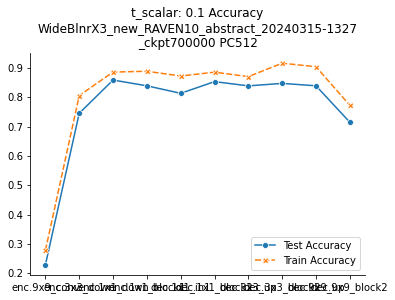

In [45]:
plt.figure(figsize=(6, 4))
sns.lineplot(data=syn_df, markers=True)
plt.title(f"t_scalar: {t_scalar} Accuracy\n{expname}\n{ckpt_str} PC{PC_dim}")
saveallforms([repr_expdir, figdir],f"{expname}_t{t_str}_PC{PC_dim}{ckpt_str}_accuracy")
plt.show()

In [55]:
results_col[key]

{'train_record':       epoch      loss  accuracy
 0         0  3.856684  0.024908
 1         1  3.675911  0.048450
 2         2  3.507413  0.088883
 3         3  3.351031  0.143275
 4         4  3.206305  0.199783
 ...     ...       ...       ...
 4995   4995  0.717637  0.772233
 4996   4996  0.717634  0.772242
 4997   4997  0.717632  0.772233
 4998   4998  0.717629  0.772233
 4999   4999  0.717626  0.772275
 
 [5000 rows x 3 columns],
 'test_record':    epoch  accuracy
 0    999  0.694150
 1   1999  0.707625
 2   2999  0.712950
 3   3999  0.714650
 4   4999  0.714825,
 'test_acc': 0.714825,
 'pred_cls': tensor([ 0,  0,  0,  ..., 39, 39, 39], device='cuda:0')}

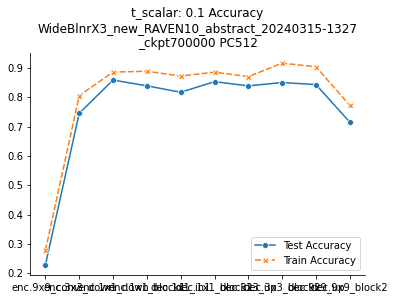

In [56]:
test_acc_synopsis = {key: results_col[key].test_record.accuracy.max() for key in results_col.keys()}
train_acc_synopsis = {key: results_col[key].train_record.accuracy.max() for key in results_col.keys()}
syn_df = pd.DataFrame([test_acc_synopsis, train_acc_synopsis]).T
syn_df.columns = ["Test Accuracy", "Train Accuracy"]

plt.figure(figsize=(6, 4))
sns.lineplot(data=syn_df, markers=True)
plt.title(f"t_scalar: {t_scalar} Accuracy\n{expname}\n{ckpt_str} PC{PC_dim}")
# saveallforms([repr_expdir, figdir],f"{expname}_t{t_str}_PC{PC_dim}{ckpt_str}_accuracy")
plt.show()

In [39]:
feature_col[layerkey].reshape(len(train_dataset),-1)

tensor([[ 3.5380,  3.8611,  3.6785,  ...,  1.3311, 10.8773,  1.1613],
        [ 2.6661,  2.7481,  3.9891,  ..., -4.2326,  7.9226,  0.2241],
        [ 2.9535,  2.5597,  1.8490,  ...,  1.8839, 10.1603, -2.0479],
        ...,
        [ 5.4787,  4.8186,  5.5408,  ..., -1.9111,  1.2289,  0.0764],
        [ 2.8093, -1.0542,  3.9364,  ...,  2.2130,  2.9810, -0.6629],
        [ 4.0964,  3.1155,  2.2594,  ...,  0.1943, -1.2307, -0.2258]])